# **🍷 와인 품질 분류 문제 🍷**


*   와인의 화학적 성분을 통해 와인 품질 예측



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

# **1. Data/library Import**

In [ ]:
# 데이터 불러오기 라이브러리
import pandas as pd
import numpy as np
import random as rnd

# 시각화 라이브러리
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import missingno as msno
from scipy.stats import norm
from scipy import stats

import warnings
warnings.filterwarnings(action='ignore')

In [ ]:
import os
if os.name == 'posix':
    plt.rc("font", family="AppleGothic")

else:
    plt.rc("font", family="Malgun Gothic")
from matplotlib import font_manager, rc
rc("font", family="Malgun Gothic", size=18, weight='light')

In [ ]:
train = pd.read_csv('/content/drive/MyDrive/train(6).csv') # 모델 학습 데이터
test = pd.read_csv('/content/drive/MyDrive/test(6).csv') # 모델 테스트 데이터
submission = pd.read_csv('/content/drive/MyDrive/submission(6).csv')

In [ ]:
train.shape, test.shape, submission.shape

((5497, 14), (1000, 13), (1000, 2))

# **Data Dictionary**
**index**: 구분자

**quality**: 맛으로 평가된 와인의 품질 (3~9)

**fixed acidity**: 산도: 와인과 관련된 대부분의 산

**volatile acidity**: 휘발성산: 와인에 함유된 아세트산의 양. 너무 높으면 불쾌한 식초 맛을 유발함.

**citric acid**: 시트르산: 소량으로 발견되며, 와인에 풍미를 더할 수 있음

**residual sugar**: 잔당: 발표 후 와인 속에 남아 있는 당

**chlorides**: 염화물: 와인의 염분량

**free sulfur dioxide**: 유리 이산화황: 미생물의 성장과 와인의 산화를 방지함

**total sulfur dioxide**: 총 이산화황: 저농도에서는 대부분 맛이 나지 않으나 50ppm에서 뚜렷하게 나타남

**density**: 밀도: 알코올 및 당 함량에 따라 변함

**pH**: 수소이온농도: 산성 또는 염기성 정도

**sulphates**: 황산염: 이산화황 농도에 기여할 수 있는 와인 첨가제. 향균 및 항산화제로 작용

**alcohol**: 도수: 와인의 알코올 함량 백분율

**type**: 와인에 사용된 포도 종류 Red (적포도주) White (백포도주)

In [ ]:
train.head(10)

index  quality  fixed acidity  volatile acidity  citric acid  \
0      0        5            5.6             0.695         0.06   
1      1        5            8.8             0.610         0.14   
2      2        5            7.9             0.210         0.39   
3      3        6            7.0             0.210         0.31   
4      4        6            7.8             0.400         0.26   
5      5        6            6.0             0.190         0.37   
6      6        5            6.1             0.220         0.49   
7      7        6            7.1             0.380         0.42   
8      8        5            6.8             0.240         0.31   
9      9        5            6.8             0.390         0.35   

   residual sugar  chlorides  free sulfur dioxide  total sulfur dioxide  \
0             6.8      0.042                  9.0                  84.0   
1             2.4      0.067                 10.0                  42.0   
2             2.0      0.057                 21.0                 138.0   
3             6.0      0.046                 29.0                 108.0   
4             9.5      0.059                 32.0                 178.0   
5             9.7      0.032                 17.0                  50.0   
6             1.5      0.051                 18.0                  87.0   
7            11.8      0.041                 32.0                 193.0   
8            18.3      0.046                 40.0                 142.0   
9            11.6      0.044                 57.0                 220.0   

   density    pH  sulphates  alcohol   type  
0  0.99432  3.44       0.44     10.2  white  
1  0.99690  3.19       0.59      9.5    red  
2  0.99176  3.05       0.52     10.9  white  
3  0.99390  3.26       0.50     10.8  white  
4  0.99550  3.04       0.43     10.9  white  
5  0.99320  3.08       0.66     12.0  white  
6  0.99280  3.30       0.46      9.6  white  
7  0.99624  3.04       0.49     10.0  white  
8  1.00000  3.30       0.41      8.7  white  
9  0.99775  3.07       0.53      9.3  white

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5497 entries, 0 to 5496
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   index                 5497 non-null   int64  
 1   quality               5497 non-null   int64  
 2   fixed acidity         5497 non-null   float64
 3   volatile acidity      5497 non-null   float64
 4   citric acid           5497 non-null   float64
 5   residual sugar        5497 non-null   float64
 6   chlorides             5497 non-null   float64
 7   free sulfur dioxide   5497 non-null   float64
 8   total sulfur dioxide  5497 non-null   float64
 9   density               5497 non-null   float64
 10  pH                    5497 non-null   float64
 11  sulphates             5497 non-null   float64
 12  alcohol               5497 non-null   float64
 13  type                  5497 non-null   object 
dtypes: float64(11), int64(2), object(1)
memory usage: 601.4+ KB


In [ ]:
train['quality'].value_counts()

6    2416
5    1788
7     924
4     186
8     152
3      26
9       5
Name: quality, dtype: int64



*   타깃변수 quality가 연속적인 값이 아닌 1 단위로 끊어지는 평점
*   해당 문제는 **분류 문제**로 해결!





In [ ]:
train.set_index('index', inplace=True)
test.set_index('index', inplace=True)
len_train_df = len(train)
len_test_df = len(test)
train

quality  fixed acidity  volatile acidity  citric acid  residual sugar  \
index                                                                          
0            5            5.6             0.695         0.06             6.8   
1            5            8.8             0.610         0.14             2.4   
2            5            7.9             0.210         0.39             2.0   
3            6            7.0             0.210         0.31             6.0   
4            6            7.8             0.400         0.26             9.5   
...        ...            ...               ...          ...             ...   
5492         5            7.7             0.150         0.29             1.3   
5493         6            6.3             0.180         0.36             1.2   
5494         7            7.8             0.150         0.34             1.1   
5495         5            6.6             0.410         0.31             1.6   
5496         6            7.0             0.350         0.17             1.1   

       chlorides  free sulfur dioxide  total sulfur dioxide  density    pH  \
index                                                                        
0          0.042                  9.0                  84.0  0.99432  3.44   
1          0.067                 10.0                  42.0  0.99690  3.19   
2          0.057                 21.0                 138.0  0.99176  3.05   
3          0.046                 29.0                 108.0  0.99390  3.26   
4          0.059                 32.0                 178.0  0.99550  3.04   
...          ...                  ...                   ...      ...   ...   
5492       0.029                 10.0                  64.0  0.99320  3.35   
5493       0.034                 26.0                 111.0  0.99074  3.16   
5494       0.035                 31.0                  93.0  0.99096  3.07   
5495       0.042                 18.0                 101.0  0.99195  3.13   
5496       0.049                  7.0                 119.0  0.99297  3.13   

       sulphates  alcohol   type  
index                             
0           0.44     10.2  white  
1           0.59      9.5    red  
2           0.52     10.9  white  
3           0.50     10.8  white  
4           0.43     10.9  white  
...          ...      ...    ...  
5492        0.39     10.1  white  
5493        0.51     11.0  white  
5494        0.72     11.3  white  
5495        0.41     10.5  white  
5496        0.36      9.7  white  

[5497 rows x 13 columns]

In [ ]:
object_col = train.select_dtypes(include='object')	
int_col = train.select_dtypes(exclude='object')	
object_col.columns, int_col.columns

(Index(['type'], dtype='object'),
 Index(['quality', 'fixed acidity', 'volatile acidity', 'citric acid',
        'residual sugar', 'chlorides', 'free sulfur dioxide',
        'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol'],
       dtype='object'))

In [ ]:
train.describe()

quality  fixed acidity  volatile acidity  citric acid  \
count  5497.000000    5497.000000       5497.000000  5497.000000   
mean      5.818992       7.210115          0.338163     0.318543   
std       0.870311       1.287579          0.163224     0.145104   
min       3.000000       3.800000          0.080000     0.000000   
25%       5.000000       6.400000          0.230000     0.250000   
50%       6.000000       7.000000          0.290000     0.310000   
75%       6.000000       7.700000          0.400000     0.390000   
max       9.000000      15.900000          1.580000     1.660000   

       residual sugar    chlorides  free sulfur dioxide  total sulfur dioxide  \
count     5497.000000  5497.000000          5497.000000           5497.000000   
mean         5.438075     0.055808            30.417682            115.566491   
std          4.756676     0.034653            17.673881             56.288223   
min          0.600000     0.009000             1.000000              6.000000   
25%          1.800000     0.038000            17.000000             78.000000   
50%          3.000000     0.047000            29.000000            118.000000   
75%          8.100000     0.064000            41.000000            155.000000   
max         65.800000     0.610000           289.000000            440.000000   

           density           pH    sulphates      alcohol  
count  5497.000000  5497.000000  5497.000000  5497.000000  
mean      0.994673     3.219502     0.530524    10.504918  
std       0.003014     0.160713     0.149396     1.194524  
min       0.987110     2.740000     0.220000     8.000000  
25%       0.992300     3.110000     0.430000     9.500000  
50%       0.994800     3.210000     0.510000    10.300000  
75%       0.996930     3.320000     0.600000    11.300000  
max       1.038980     4.010000     2.000000    14.900000

In [ ]:
train['quality'].value_counts()

6    2416
5    1788
7     924
4     186
8     152
3      26
9       5
Name: quality, dtype: int64

In [ ]:
train.isnull().sum()
print("\n--------------------------")
test.isnull().sum()

quality                 0
fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
type                    0
dtype: int64


--------------------------


fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
type                    0
dtype: int64



*   train/test 데이터 모두 결측치가 존재하지 않기 때문에 결측치 처리할 필요가 없음



In [ ]:
train.groupby("type")["quality"].describe()

count      mean       std  min  25%  50%  75%  max
type                                                      
red    1338.0  5.637519  0.802575  3.0  5.0  6.0  6.0  8.0
white  4159.0  5.877374  0.883206  3.0  5.0  6.0  6.0  9.0



*   red 와인 1338개 
*   white 와인 4159개



In [ ]:
train.describe()

quality  fixed acidity  volatile acidity  citric acid  \
count  5497.000000    5497.000000       5497.000000  5497.000000   
mean      5.818992       7.210115          0.338163     0.318543   
std       0.870311       1.287579          0.163224     0.145104   
min       3.000000       3.800000          0.080000     0.000000   
25%       5.000000       6.400000          0.230000     0.250000   
50%       6.000000       7.000000          0.290000     0.310000   
75%       6.000000       7.700000          0.400000     0.390000   
max       9.000000      15.900000          1.580000     1.660000   

       residual sugar    chlorides  free sulfur dioxide  total sulfur dioxide  \
count     5497.000000  5497.000000          5497.000000           5497.000000   
mean         5.438075     0.055808            30.417682            115.566491   
std          4.756676     0.034653            17.673881             56.288223   
min          0.600000     0.009000             1.000000              6.000000   
25%          1.800000     0.038000            17.000000             78.000000   
50%          3.000000     0.047000            29.000000            118.000000   
75%          8.100000     0.064000            41.000000            155.000000   
max         65.800000     0.610000           289.000000            440.000000   

           density           pH    sulphates      alcohol  
count  5497.000000  5497.000000  5497.000000  5497.000000  
mean      0.994673     3.219502     0.530524    10.504918  
std       0.003014     0.160713     0.149396     1.194524  
min       0.987110     2.740000     0.220000     8.000000  
25%       0.992300     3.110000     0.430000     9.500000  
50%       0.994800     3.210000     0.510000    10.300000  
75%       0.996930     3.320000     0.600000    11.300000  
max       1.038980     4.010000     2.000000    14.900000

# **2. EDA**

##**2.0 품질별 분포 확인**

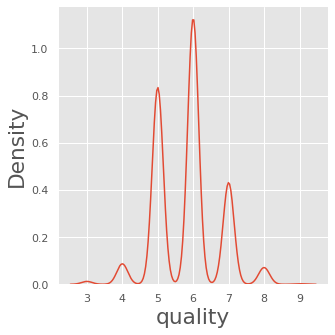

In [ ]:
sns.displot(train["quality"], kind='kde')

<Figure size 936x720 with 0 Axes>

Text(0.5, 1.0, 'Quailty')

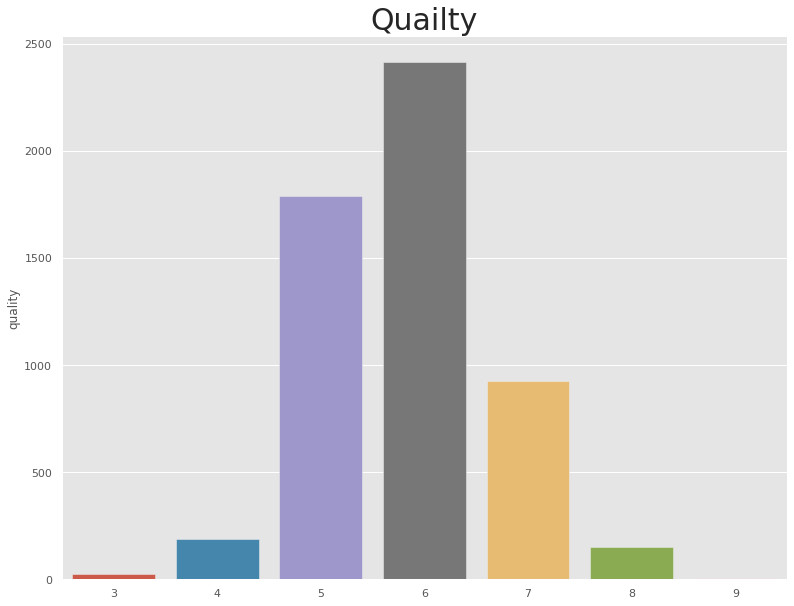

In [ ]:
count = train['quality'].value_counts()
plt.style.use('ggplot')
plt.figure(figsize=(13,10))
plt.title('Quailty',fontsize=30)
sns.barplot(x=count.index, y=count)



*   와인의 품질은 3~9까지 분포
*   train data의 대부분이 **5, 6**에 분포되어 있음, 불균형 심한 편
*   5, 6 이외의 다른 품질 클래스에서의 모델 데이터가 부족하기 때문에 해당 클래스를 맞추는 데에 있어서는 정확도가 떨어질 위험 존재 









In [ ]:
train['quality'].describe()

count    5497.000000
mean        5.818992
std         0.870311
min         3.000000
25%         5.000000
50%         6.000000
75%         6.000000
max         9.000000
Name: quality, dtype: float64

# **각 특성들의 분포 확인**


<Figure size 864x864 with 0 Axes>

Text(0.5, 1.0, 'QUALITY')

Text(0.5, 0, '')

Text(0, 0.5, '')

Text(0.5, 1.0, 'FIXED ACIDITY')

Text(0.5, 0, '')

Text(0, 0.5, '')

Text(0.5, 1.0, 'VOLATILE ACIDITY')

Text(0.5, 0, '')

Text(0, 0.5, '')

Text(0.5, 1.0, 'CITRIC ACID')

Text(0.5, 0, '')

Text(0, 0.5, '')

Text(0.5, 1.0, 'RESIDUAL SUGAR')

Text(0.5, 0, '')

Text(0, 0.5, '')

Text(0.5, 1.0, 'CHLORIDES')

Text(0.5, 0, '')

Text(0, 0.5, '')

Text(0.5, 1.0, 'FREE SULFUR DIOXIDE')

Text(0.5, 0, '')

Text(0, 0.5, '')

Text(0.5, 1.0, 'TOTAL SULFUR DIOXIDE')

Text(0.5, 0, '')

Text(0, 0.5, '')

Text(0.5, 1.0, 'DENSITY')

Text(0.5, 0, '')

Text(0, 0.5, '')

Text(0.5, 1.0, 'PH')

Text(0.5, 0, '')

Text(0, 0.5, '')

Text(0.5, 1.0, 'SULPHATES')

Text(0.5, 0, '')

Text(0, 0.5, '')

Text(0.5, 1.0, 'ALCOHOL')

Text(0.5, 0, '')

Text(0, 0.5, '')

<Figure size 864x864 with 0 Axes>

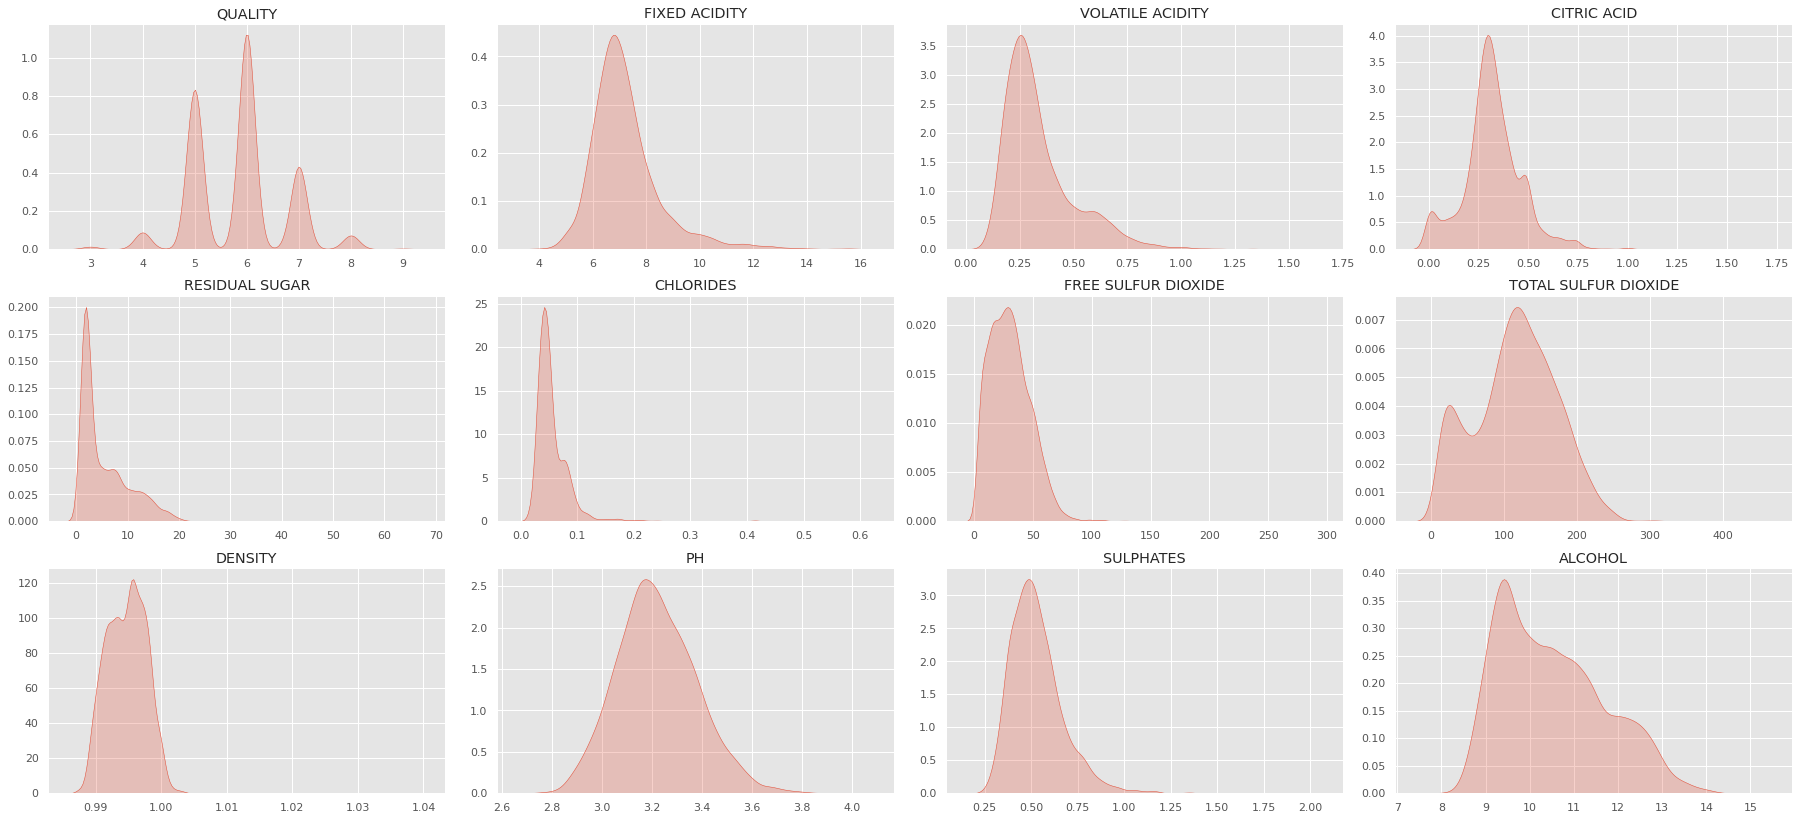

In [ ]:
plt.figure(figsize=(12,12))
fig, axs = plt.subplots(3, 4, figsize=(25, 15))
for i,col in enumerate(list(int_col)):
    plt.subplot(4,4,i+1)
    sns.kdeplot(data=train[col],shade=True)
    plt.title(col.upper())
    plt.xlabel(None)
    plt.ylabel(None)
    
plt.tight_layout()



*   



# **와인 품질에 따른 각 특성들 간의 어떠한 차이가 존재할까?**


*   와인 클래스에 따른 feature 들의 평균값들로 데이터 프레임 생성 후 시각화하여 클래스 간의 변화 관찰



In [ ]:
qty = train[train['quality']==3].drop(['quality'],axis=1).describe()
qty

fixed acidity  volatile acidity  citric acid  residual sugar  \
count      26.000000         26.000000    26.000000       26.000000   
mean        7.811538          0.538077     0.266923        5.203846   
std         1.751189          0.358832     0.182269        4.490922   
min         4.200000          0.170000     0.000000        1.150000   
25%         6.825000          0.252500     0.090000        2.025000   
50%         7.450000          0.435000     0.275000        3.450000   
75%         8.450000          0.730000     0.395000        7.800000   
max        11.800000          1.580000     0.660000       16.200000   

       chlorides  free sulfur dioxide  total sulfur dioxide    density  \
count  26.000000            26.000000             26.000000  26.000000   
mean    0.076500            40.096154            121.461538   0.995713   
std     0.065056            64.514342            118.977807   0.002871   
min     0.022000             3.000000              9.000000   0.991100   
25%     0.037250             5.000000             21.500000   0.993750   
50%     0.050000            15.500000             81.000000   0.995400   
75%     0.081000            37.375000            200.000000   0.998060   
max     0.267000           289.000000            440.000000   1.000800   

              pH  sulphates    alcohol  
count  26.000000  26.000000  26.000000  
mean    3.250385   0.500000  10.251923  
std     0.227042   0.113066   1.126630  
min     2.870000   0.280000   8.000000  
25%     3.072500   0.407500   9.625000  
50%     3.245000   0.505000  10.150000  
75%     3.435000   0.565000  11.000000  
max     3.630000   0.740000  12.600000

In [ ]:
for i in range(3,10):
  qty = train[train['quality']==i].drop(['quality'],axis=1).describe()
  if i==3:
    data = pd.DataFrame({i:qty.loc['mean']})
  else:
    dt = pd.DataFrame({i:qty.loc['mean']})
    data = pd.concat([data,dt],axis=1)

In [ ]:
data = data.T
data

fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
3       7.811538          0.538077     0.266923        5.203846   0.076500   
4       7.269892          0.447285     0.280323        4.145430   0.059247   
5       7.329195          0.387855     0.308043        5.792422   0.064417   
6       7.166743          0.312301     0.323411        5.535141   0.053932   
7       7.123972          0.289724     0.332987        4.748918   0.045352   
8       6.839474          0.292730     0.330263        5.581579   0.041105   
9       7.420000          0.298000     0.386000        4.120000   0.027400   

   free sulfur dioxide  total sulfur dioxide   density        pH  sulphates  \
3            40.096154            121.461538  0.995713  3.250385   0.500000   
4            20.553763            104.811828  0.994730  3.228602   0.500484   
5            30.174217            120.370805  0.995843  3.213384   0.525017   
6            30.969578            115.357616  0.994527  3.219611   0.532686   
7            30.457251            108.178571  0.993122  3.228333   0.546786   
8            34.585526            119.421053  0.992544  3.216711   0.506184   
9            33.400000            116.000000  0.991460  3.308000   0.466000   

     alcohol  
3  10.251923  
4  10.180376  
5   9.846875  
6  10.606015  
7  11.383864  
8  11.680921  
9  12.180000

Text(0.5, 0.98, 'Features  mean for each class')

Text(0.5, 1.0, 'fixed acidity')

Text(0.5, 1.0, 'volatile acidity')

Text(0.5, 1.0, 'citric acid')

Text(0.5, 1.0, 'residual sugar')

Text(0.5, 1.0, 'chlorides')

Text(0.5, 1.0, 'free sulfur dioxide')

Text(0.5, 1.0, 'total sulfur dioxide')

Text(0.5, 1.0, 'density')

Text(0.5, 1.0, 'pH')

Text(0.5, 1.0, 'sulphates')

Text(0.5, 1.0, 'alcohol')

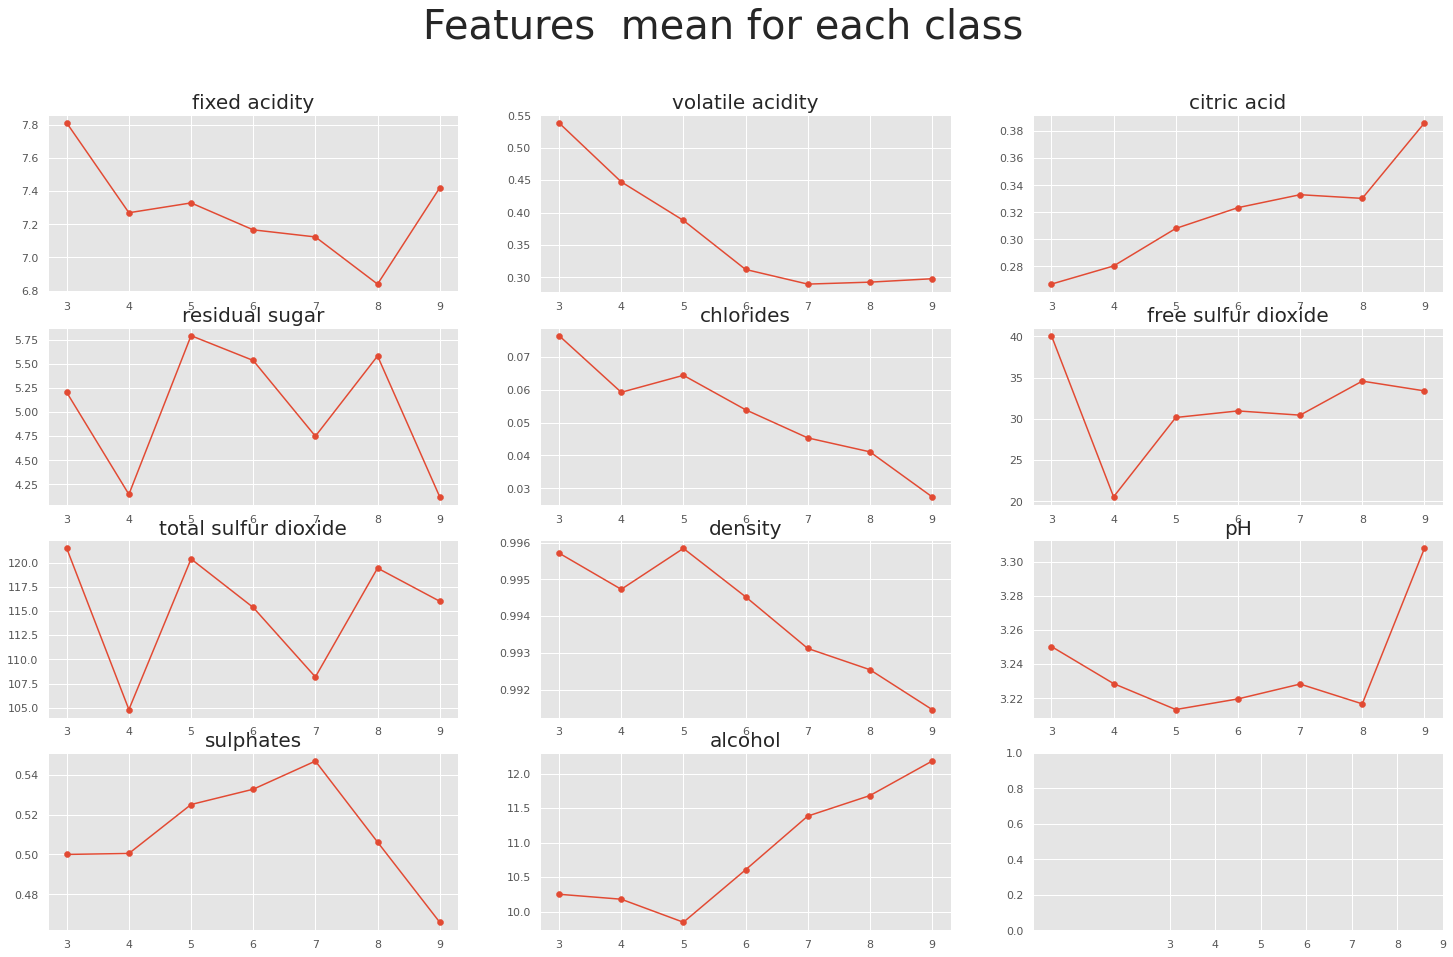

In [ ]:
fig, axes = plt.subplots(4, 3, figsize=(25, 15))

fig.suptitle('Features  mean for each class', fontsize=40)
for ax, col in zip(axes.flat, data.columns):
  ax.plot([3,4,5,6,7,8,9], data[col])
  ax.scatter([3,4,5,6,7,8,9], data[col])
  ax.set_title(col, fontsize=20)
plt.setp(axes, xticks=[3,4,5,6,7,8,9])
plt.show()





*   **fixed acidity (산도)**: 와인 품질 높아질수록 낮아지는 경향을 보이다가 8->9 구간에서 증가
*   **volatile acidity (휘발성산)**: 와인 품질 높아질수록 낮아지는 경향을 보이다가 7->9 구간에서 미세하게 증가
*  **citric acid (시트르산)**: 와인 품질 높아질수록 높아지는 경향을 보임 (와인에 풍미를 더해 줄수록 품질 좋아짐)


---


*   **residual sugar (잔당)**: 와인 품질에 따른 주목할만한 변화 보이지 않음
*   **chlorides (염화물)**: 4->5 구간 제외하고, 와인 품질 높아질수록 지속적으로 감소하는 경향을 보임 (염분량이 적어질수록 품질 좋아짐)
*   **free sulfur dioxide (유리 이산화황)**: 3->4, 8->9 제외하고, 와인 품질 증가할수록 증가하는 경향을 보임 (와인 산화방지할수록 품질 좋아짐)


---


*  **total sulfur dioxide (총 이산화황)**: 와인 품질에 따른 주목할만한 변화 보이지 않음
*   **density (밀도)**: 4->5 구간 제외하고, 와인 품질 증가할수록 감소하는 경향을 보임
*   **pH (수소이온농도)**: 3->5, 7->8 구간에서 감소, 5->7 구간에서 증가, 8->9 구간에서 급격하게 증가하는 경향을 보임


---


*   **sulphates (황산염)**: 와인 품질 높아질수록 높아지는 경향을 보이다가 7->9 구간에서 감소
*   **alcohol (도수)**: 3->5 구간 이후 와인 품질 높아질수록 높아지는 경향을 보임










*   바이올린 플롯을 통해 대략적인 분포 확인



Text(0.5, 0.98, 'feature distributions for each class')

Text(0.5, 1.0, 'volatile acidity')

Text(0.5, 1.0, 'citric acid')

Text(0.5, 1.0, 'residual sugar')

Text(0.5, 1.0, 'chlorides')

Text(0.5, 1.0, 'free sulfur dioxide')

Text(0.5, 1.0, 'total sulfur dioxide')

Text(0.5, 1.0, 'density')

Text(0.5, 1.0, 'pH')

Text(0.5, 1.0, 'sulphates')

Text(0.5, 1.0, 'alcohol')

Text(0.5, 1.0, 'type')

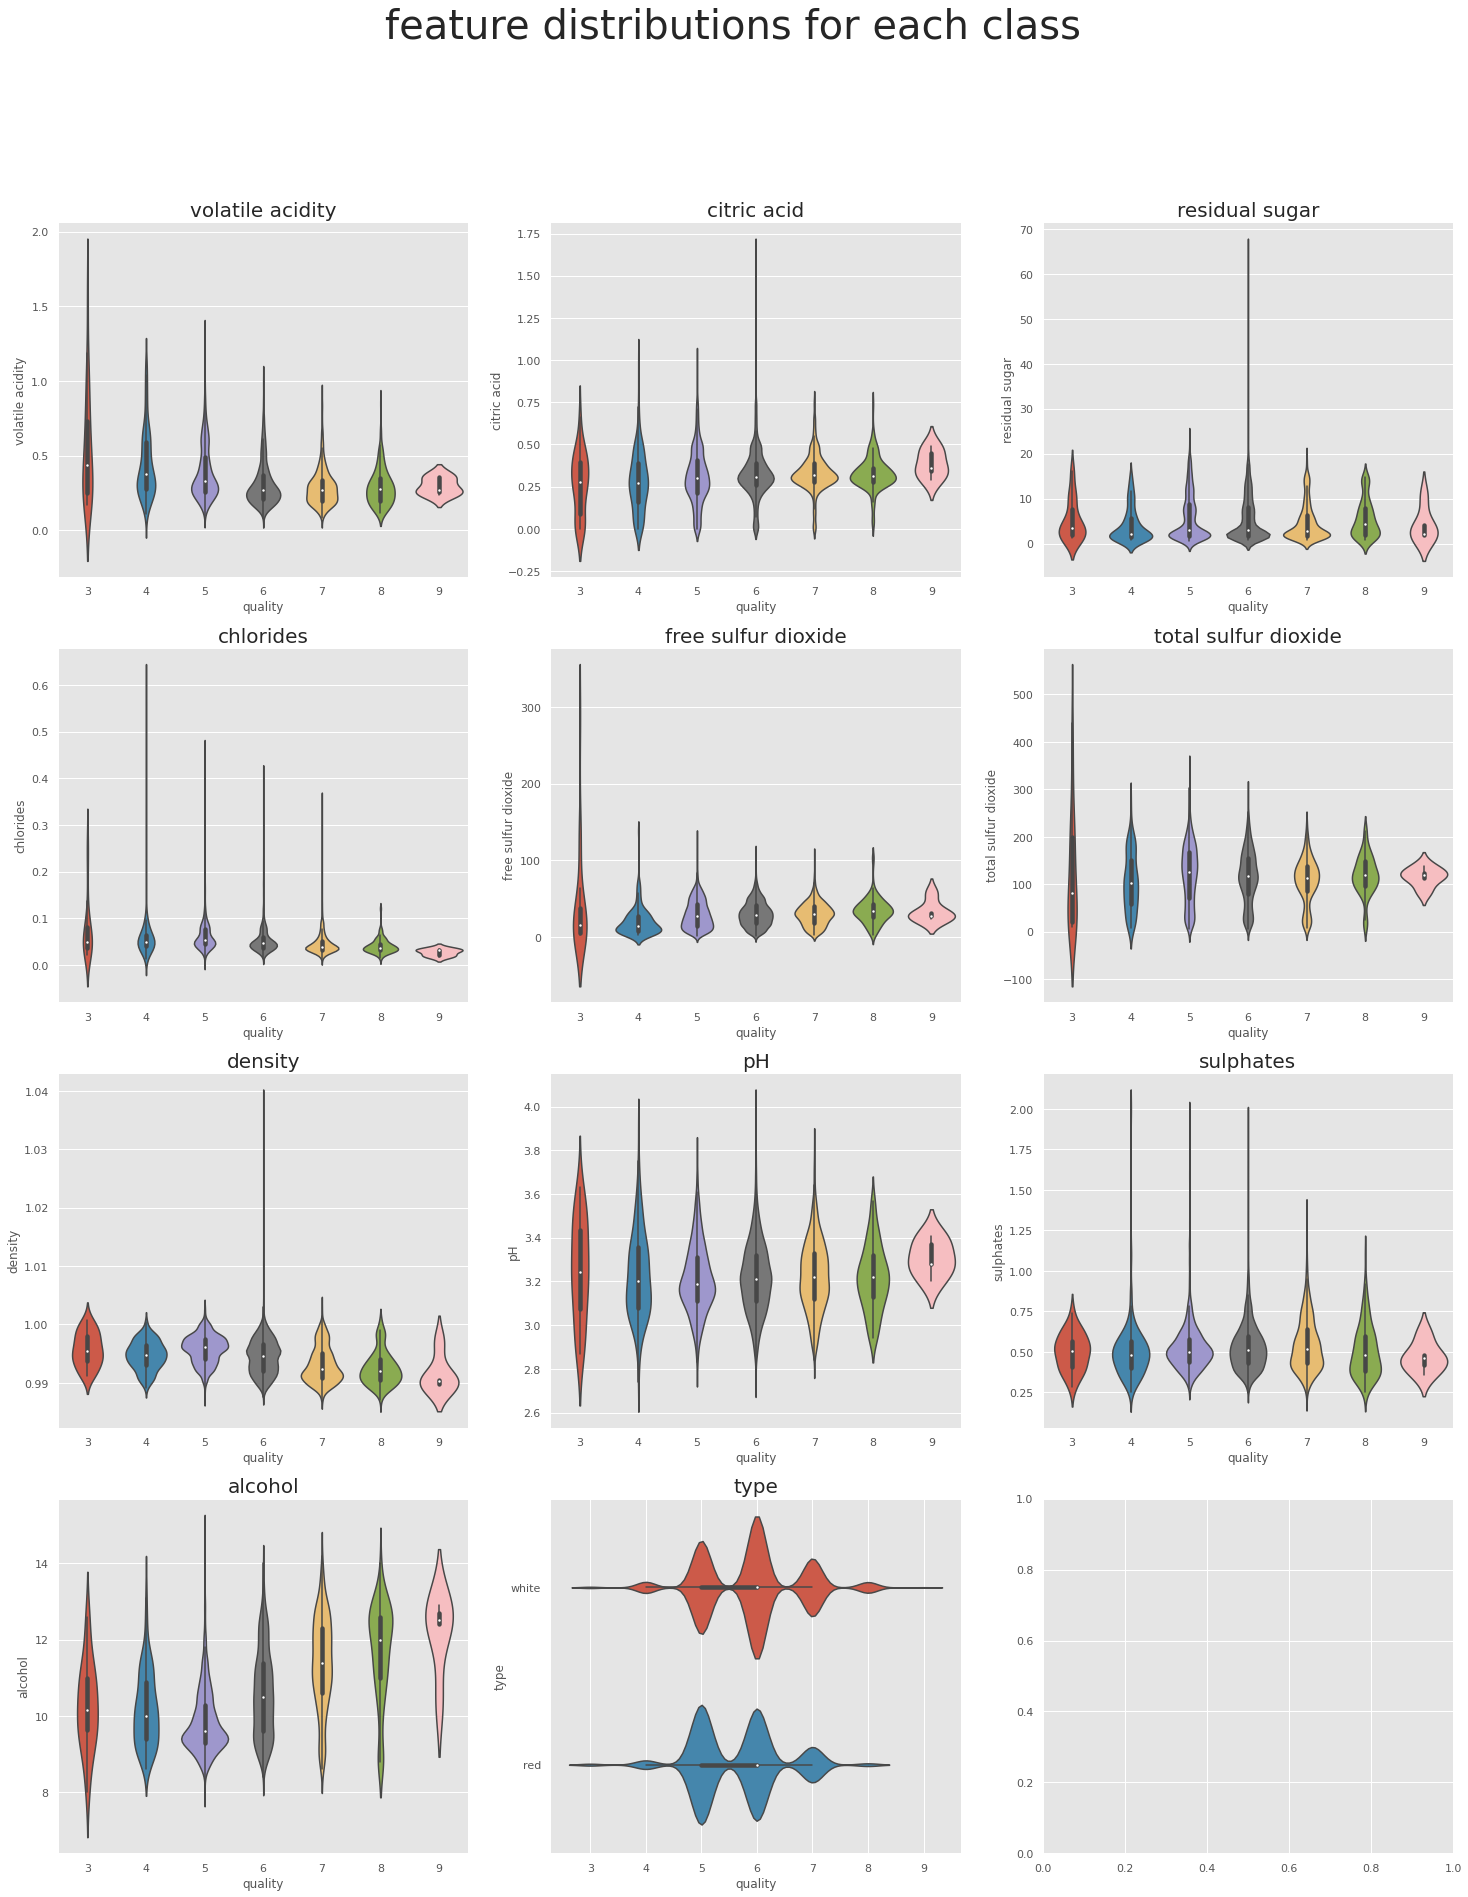

In [ ]:
fig, axes = plt.subplots(4, 3, figsize=(25, 30))

fig.suptitle('feature distributions for each class', fontsize = 40)
for ax, col in zip(axes.flat, train.columns[2:]):
  sns.violinplot(x='quality', y=col, ax=ax, data=train)
  ax.set_title(col, fontsize=20)
# plt.tight_layout()
plt.show()

# **히트맵 확인**

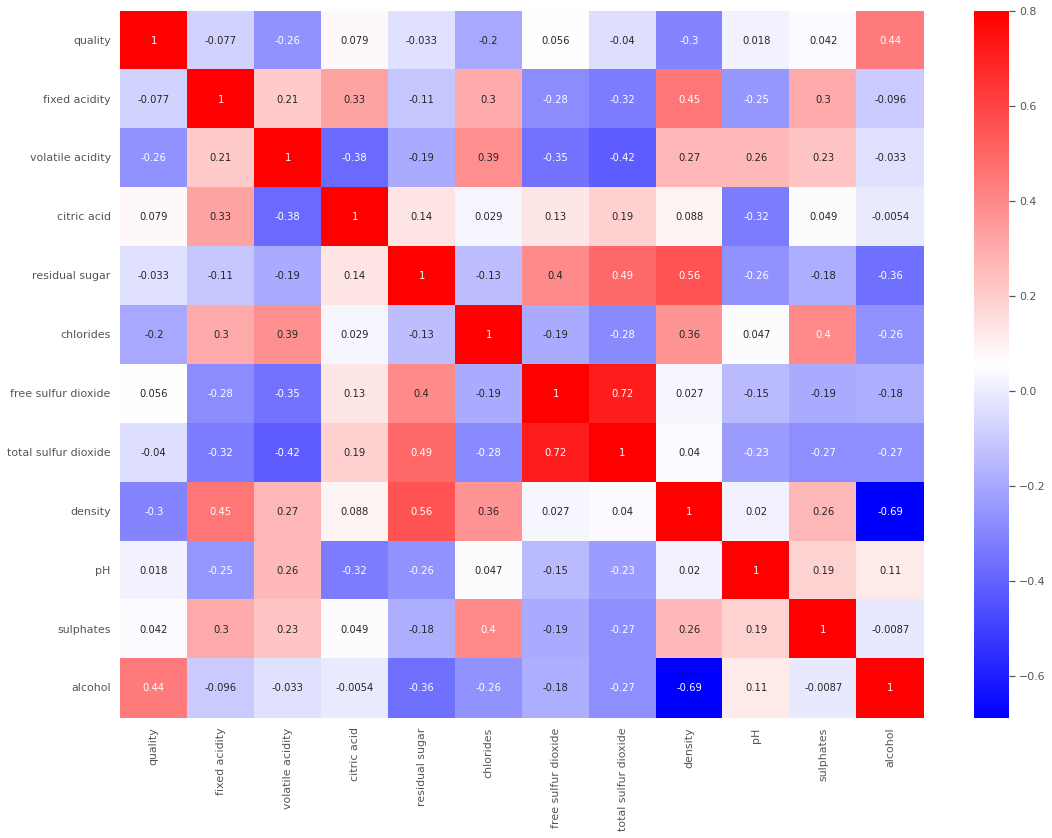

In [ ]:
f, ax = plt.subplots(figsize=(18, 13))
sns.heatmap(train.corr(), vmax=.8, annot=True, cmap='bwr')



*   와인 품질 클래스와 **alcohol** 양의 상관관계 존재



In [ ]:
corr = train.corr()
corr

quality  fixed acidity  volatile acidity  citric acid  \
quality               1.000000      -0.076506         -0.261557     0.079157   
fixed acidity        -0.076506       1.000000          0.210180     0.326992   
volatile acidity     -0.261557       0.210180          1.000000    -0.377986   
citric acid           0.079157       0.326992         -0.377986     1.000000   
residual sugar       -0.032848      -0.112544         -0.192677     0.135160   
chlorides            -0.198148       0.303307          0.385431     0.029121   
free sulfur dioxide   0.055574      -0.277079         -0.352572     0.129496   
total sulfur dioxide -0.039732      -0.323845         -0.418535     0.190955   
density              -0.299831       0.452161          0.266759     0.088400   
pH                    0.017931      -0.250462          0.264130    -0.322100   
sulphates             0.042068       0.300979          0.225174     0.049013   
alcohol               0.439615      -0.096274         -0.032897    -0.005376   

                      residual sugar  chlorides  free sulfur dioxide  \
quality                    -0.032848  -0.198148             0.055574   
fixed acidity              -0.112544   0.303307            -0.277079   
volatile acidity           -0.192677   0.385431            -0.352572   
citric acid                 0.135160   0.029121             0.129496   
residual sugar              1.000000  -0.130339             0.396018   
chlorides                  -0.130339   1.000000            -0.193143   
free sulfur dioxide         0.396018  -0.193143             1.000000   
total sulfur dioxide        0.494788  -0.281654             0.716829   
density                     0.557183   0.364200             0.027270   
pH                         -0.259673   0.046937            -0.145586   
sulphates                  -0.182275   0.400354            -0.189390   
alcohol                    -0.361457  -0.259774            -0.182321   

                      total sulfur dioxide   density        pH  sulphates  \
quality                          -0.039732 -0.299831  0.017931   0.042068   
fixed acidity                    -0.323845  0.452161 -0.250462   0.300979   
volatile acidity                 -0.418535  0.266759  0.264130   0.225174   
citric acid                       0.190955  0.088400 -0.322100   0.049013   
residual sugar                    0.494788  0.557183 -0.259673  -0.182275   
chlorides                        -0.281654  0.364200  0.046937   0.400354   
free sulfur dioxide               0.716829  0.027270 -0.145586  -0.189390   
total sulfur dioxide              1.000000  0.039707 -0.234412  -0.272236   
density                           0.039707  1.000000  0.020047   0.261879   
pH                               -0.234412  0.020047  1.000000   0.187392   
sulphates                        -0.272236  0.261879  0.187392   1.000000   
alcohol                          -0.271566 -0.688053  0.114959  -0.008713   

                       alcohol  
quality               0.439615  
fixed acidity        -0.096274  
volatile acidity     -0.032897  
citric acid          -0.005376  
residual sugar       -0.361457  
chlorides            -0.259774  
free sulfur dioxide  -0.182321  
total sulfur dioxide -0.271566  
density              -0.688053  
pH                    0.114959  
sulphates            -0.008713  
alcohol               1.000000

In [ ]:
# 타깃변수와 양의 상관관계에 있는 변수 확인

corr.loc[corr["quality"]>0,"quality"]

quality                1.000000
citric acid            0.079157
free sulfur dioxide    0.055574
pH                     0.017931
sulphates              0.042068
alcohol                0.439615
Name: quality, dtype: float64



*   품질 높아질수록 도수 > 시트르산 > 유리 이산화황 > 황산염 > 수소이온농도 수치 또한 높아짐


In [ ]:
# 타깃변수와 음의 상관관계에 있는 변수 확인

corr.loc[corr["quality"]<0,"quality"]

fixed acidity          -0.076506
volatile acidity       -0.261557
residual sugar         -0.032848
chlorides              -0.198148
total sulfur dioxide   -0.039732
density                -0.299831
Name: quality, dtype: float64

*   품질 높아질수록 밀도 > 휘발성산 > 염화물 > 산도 > 총이산화황 > 잔당 수치는 낮아짐

In [ ]:
# 타깃변수와 0의 상관관계가 아닌 변수만 추출

corr.loc[np.abs(corr["quality"])>0,"quality"]

quality                 1.000000
fixed acidity          -0.076506
volatile acidity       -0.261557
citric acid             0.079157
residual sugar         -0.032848
chlorides              -0.198148
free sulfur dioxide     0.055574
total sulfur dioxide   -0.039732
density                -0.299831
pH                      0.017931
sulphates               0.042068
alcohol                 0.439615
Name: quality, dtype: float64

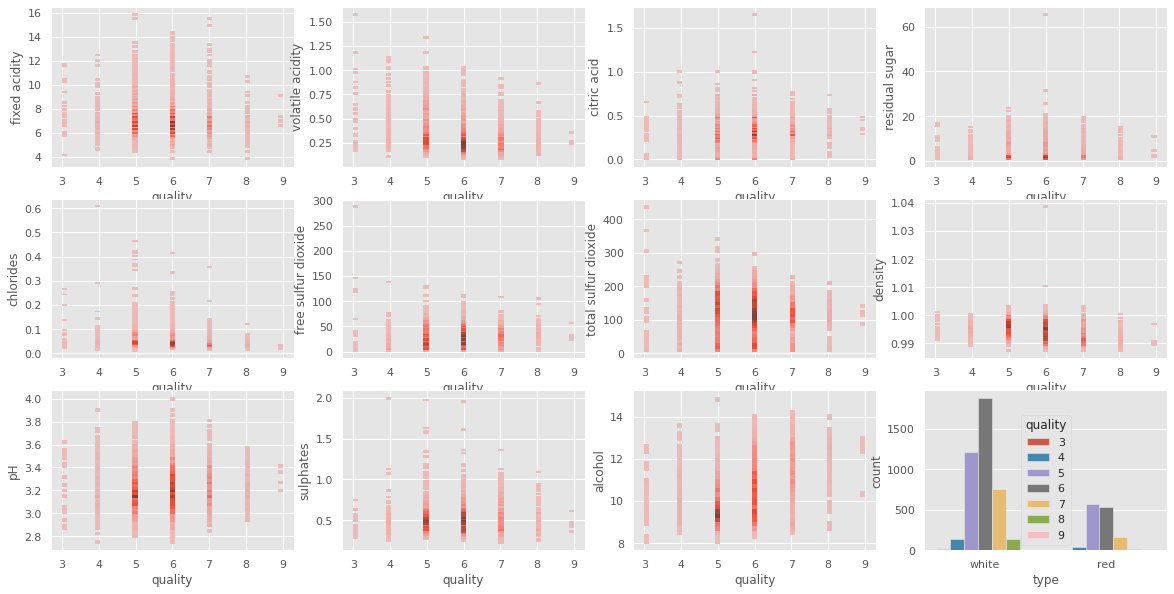

In [ ]:
figure, ax = plt.subplots(3, 4)
figure.set_size_inches(20,10)

sns.histplot(data=train, y="fixed acidity", x="quality", ax=ax[0][0])
sns.histplot(data=train, y="volatile acidity", x="quality", ax=ax[0][1])
sns.histplot(data=train, y="citric acid", x="quality", ax=ax[0][2])
sns.histplot(data=train, y="residual sugar", x="quality", ax=ax[0][3])

sns.histplot(data=train, y="chlorides", x="quality", ax=ax[1][0])
sns.histplot(data=train, y="free sulfur dioxide", x="quality", ax=ax[1][1])
sns.histplot(data=train, y="total sulfur dioxide", x="quality", ax=ax[1][2])
sns.histplot(data=train, y="density", x="quality", ax=ax[1][3])

sns.histplot(data=train, y="pH", x="quality", ax=ax[2][0])
sns.histplot(data=train, y="sulphates", x="quality", ax=ax[2][1])
sns.histplot(data=train, y="alcohol", x="quality", ax=ax[2][2])
sns.countplot(data=train, x='type', hue='quality', ax=ax[2][3])

# **산점도 행렬을 통해 변수들 간의 관계 확인**

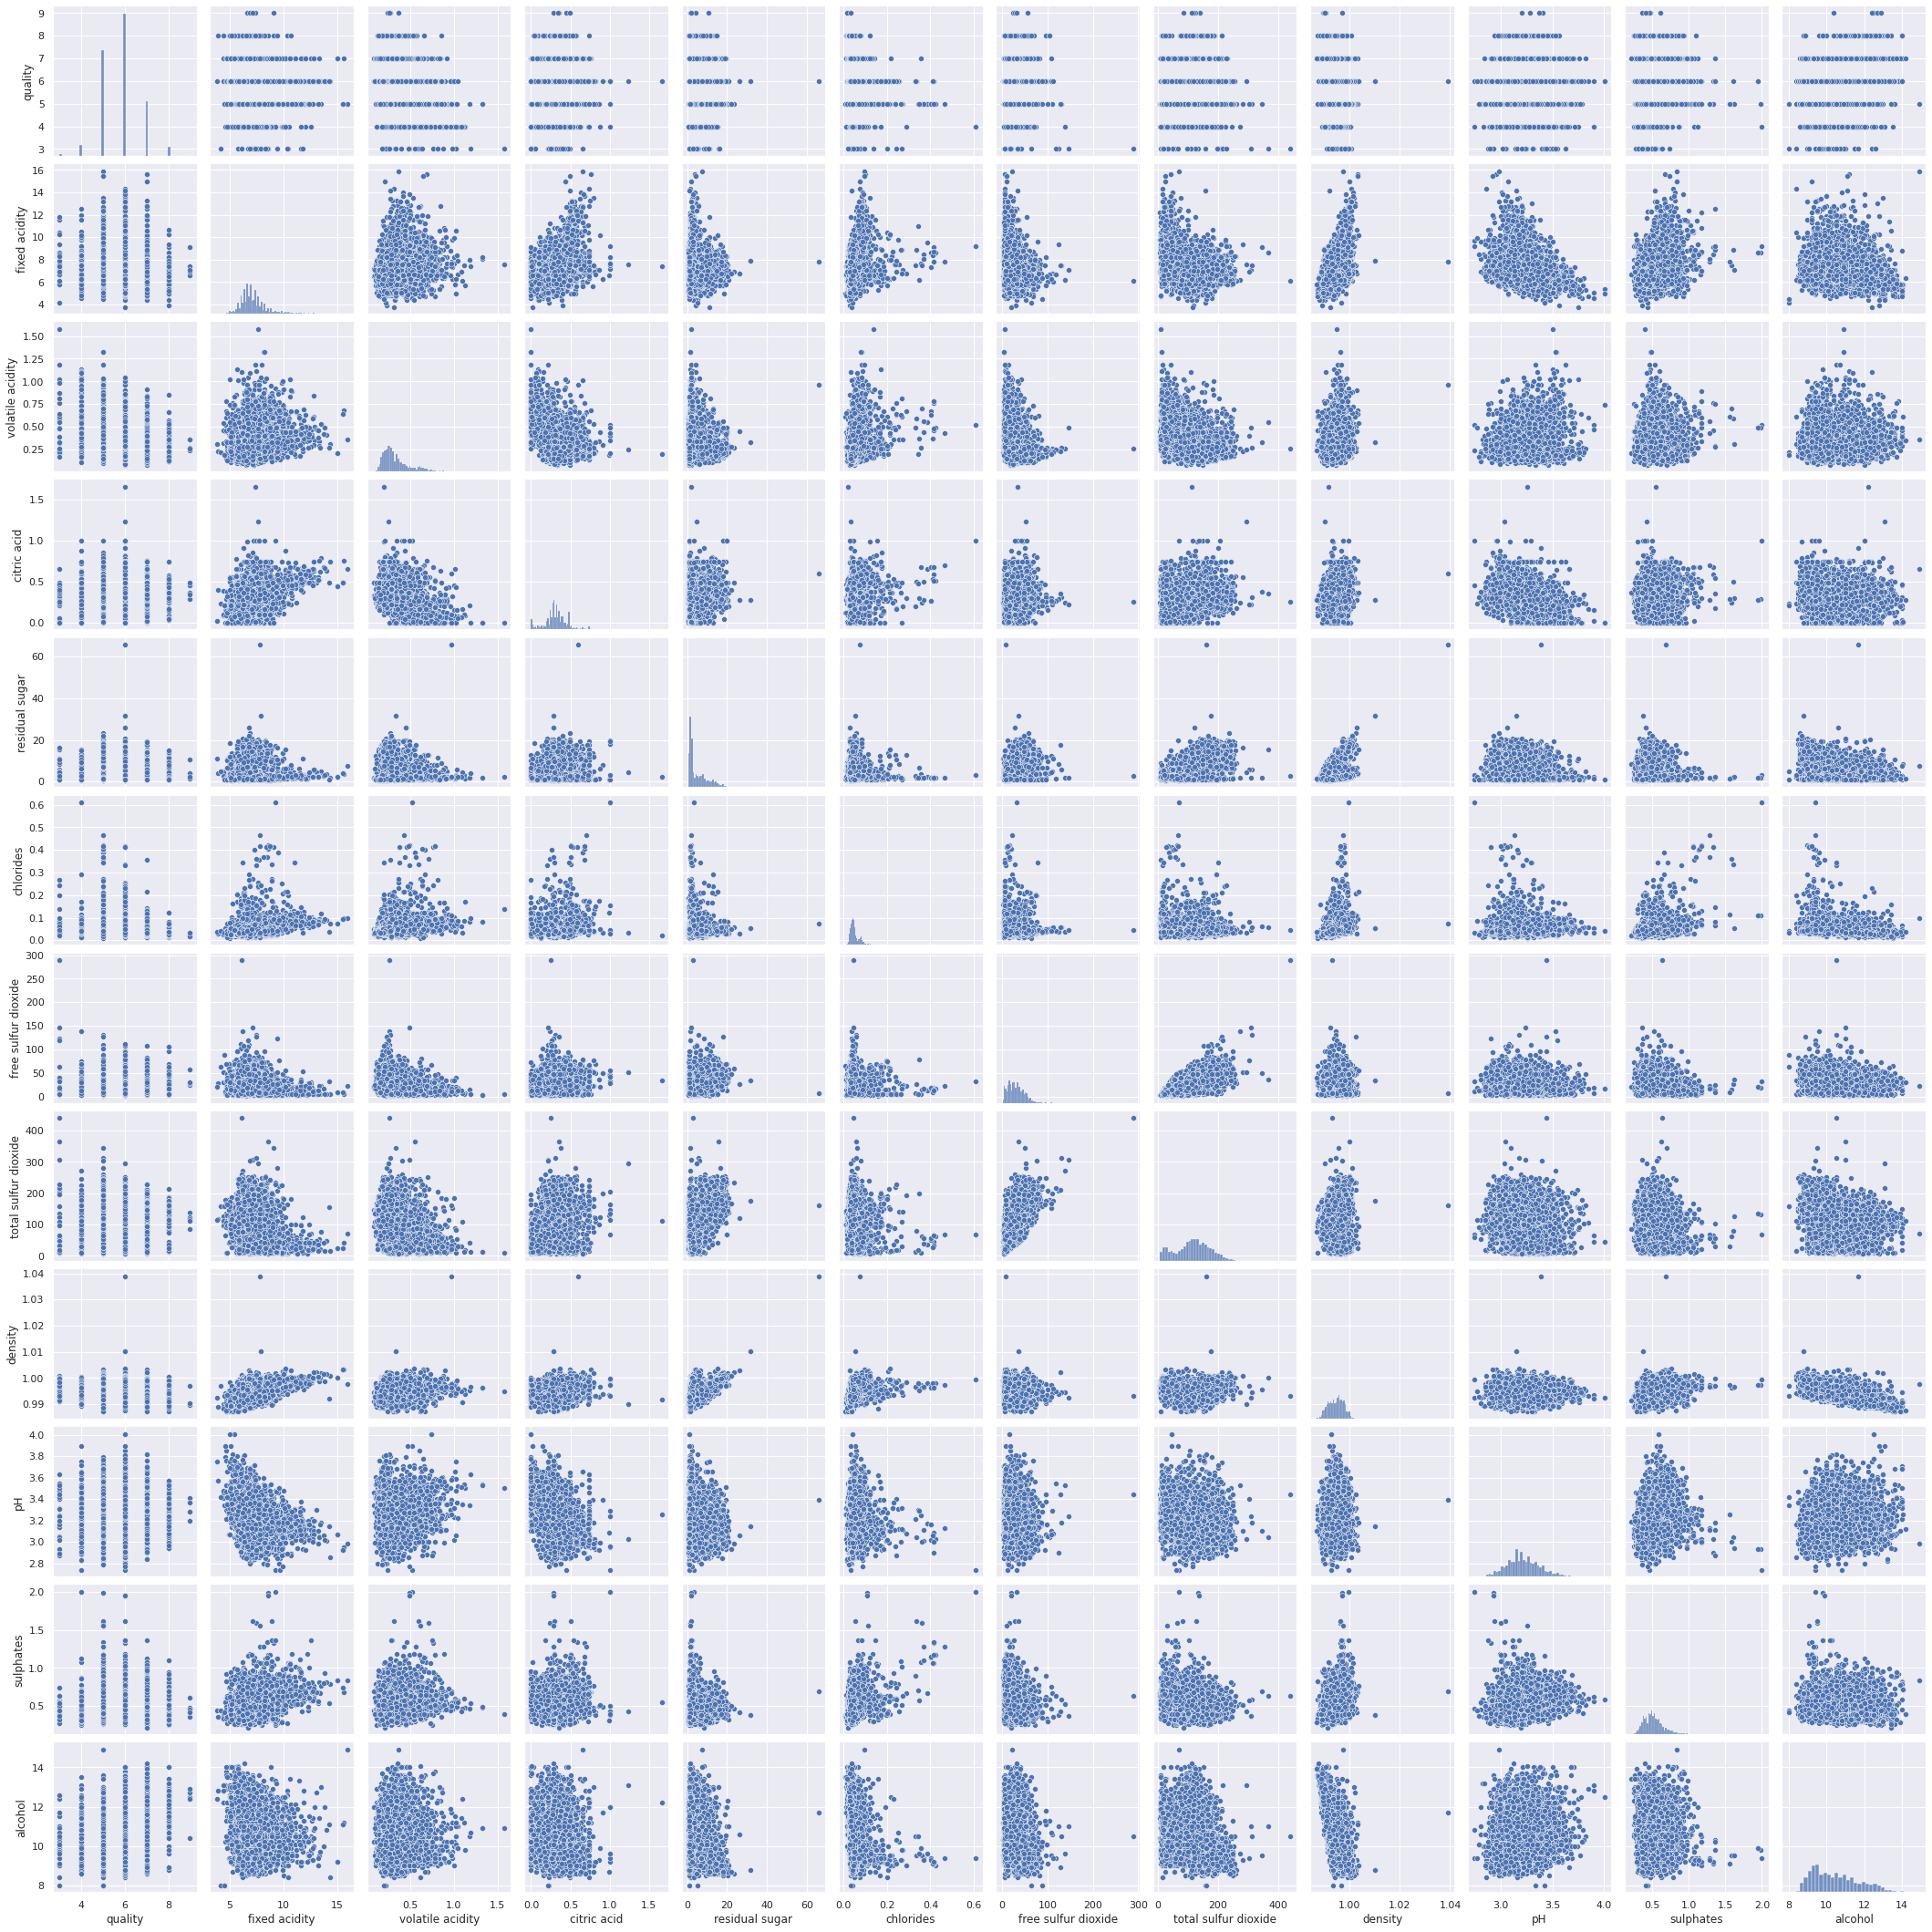

In [ ]:
sns.set()
cols = ['quality', 'fixed acidity', 'volatile acidity', 'citric acid','residual sugar', 'chlorides', 'free sulfur dioxide',
        'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol']
sns.pairplot(train[cols], size = 2.5)
plt.show()





*   fixed acidity와 density 간의 약한 양의 상관관계
*   alcohol과 density 변수 간의 약한 음의 상관관계
*   이외에 딱히 선형 관계를 보인다거나, 눈에 띠는 상관관계를 가지는 변수들은 없어 보임
*   몇몇 이상치들 제거할 필요





# **3. feature Engineering**




*   피처 제거?

*   object 형 피처 수치 변환

*   결측치는 존재하지 않았기 때문에 결측치 채우는 과정 생략


*   이상치 제거
    1. 로그변환
    2. 단위통일
    3. 기준설정








# **3.0_ 일부 특성들 제거?**

*   고품질의 와인은 다른 품질의 와인과는 드문 성분을 가질 수 있기 떄문에 와인 품질을 예측하는 동안 모든 특징 고려해야 할 필요가 있음.
*  따라서 해당 문제에서는 피처들이 약한 상관관계를 보이고 있더라도 어떠한 특징도 제거하지 않는 것이 적합하다고 판단

# **3.1_ type (와인에 사용된 포도 종류)**


*   숫자로 변환 white = 0, red = 1



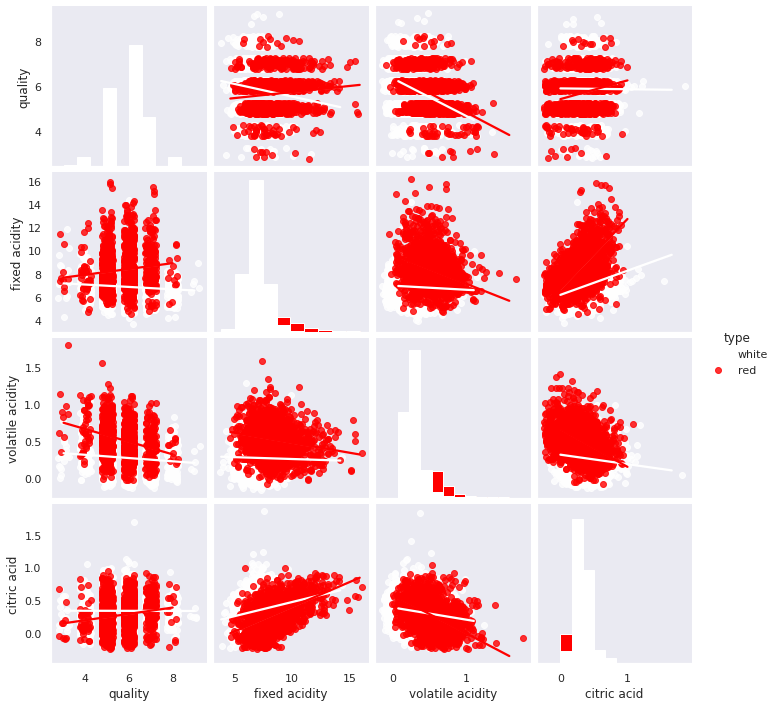

In [ ]:
sns.set_style("dark")
sns.pairplot(train,vars= ['quality', 'fixed acidity', 'volatile acidity','citric acid'],
             kind="reg",plot_kws={"ci":False,"x_jitter":0.25,"y_jitter":0.25},
             diag_kind="hist",diag_kws={"bins":10,"alpha":1},hue='type'
             ,palette=dict(red="red",white="white",marker=["o","s"]))



*   그래프 확인 결과 눈에 띠는 포도의 종류에 따른 특성 차이 보이지 않음



In [ ]:
train['type'] = np.where(train['type']=='white',0,1)
test['type'] = np.where(test['type']=='white',0,1)

In [ ]:
train['type'].value_counts()

0    4159
1    1338
Name: type, dtype: int64


*   백포도주 4159개
*   적포도주 1338개

Text(0.5, 1.0, 'quality')

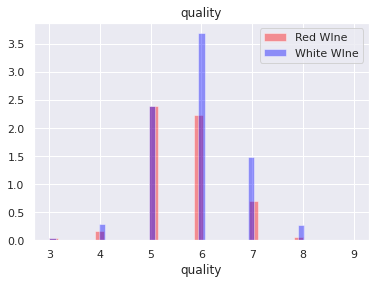

In [ ]:
red = train.loc[train["type"]==1,'quality']
white = train.loc[train['type']==0,'quality']
sns.set_style("darkgrid")
sns.distplot(red,norm_hist=True,kde=False,color="red",label="Red WIne")
sns.distplot(white,norm_hist=True,kde=False,color="blue",label="White WIne")
plt.title("quality")
plt.legend()



*   품질이 높아질수록 백포도주의 수가 적포도주에 비해 많아지지만 이는, 백포도주가 적포도주에 비해 품질이 뛰어나서라기보다는 백포도주의 수가 적포도주의 수에 비해 많기 때문에 발생할 수 밖에 없는 당연한 현상으로 해석



# **3.2_ 이상치 제거**

# **3.3.0 log scale 을 이용한 1차 이상치 제거**


*  box plot 으로 변수의 이상치 분포 확인
* 타깃 변수의 데이터 분포는 정규 분포를 나타내는 곡선을 거의 따라야 함
* 그러나 타깃 변수 quality 가 정규분포를 따르지 않기 때문에 정확도 낮아지게 만들 위험 존재
*   정규 분포 따르지 않는 feature 역시 로그 변환 필요





Text(0.5, 0.98, 'feature distributions for each class')

Text(0.5, 1.0, 'volatile acidity')

Text(0.5, 1.0, 'citric acid')

Text(0.5, 1.0, 'residual sugar')

Text(0.5, 1.0, 'chlorides')

Text(0.5, 1.0, 'free sulfur dioxide')

Text(0.5, 1.0, 'total sulfur dioxide')

Text(0.5, 1.0, 'density')

Text(0.5, 1.0, 'pH')

Text(0.5, 1.0, 'sulphates')

Text(0.5, 1.0, 'alcohol')

Text(0.5, 1.0, 'type')

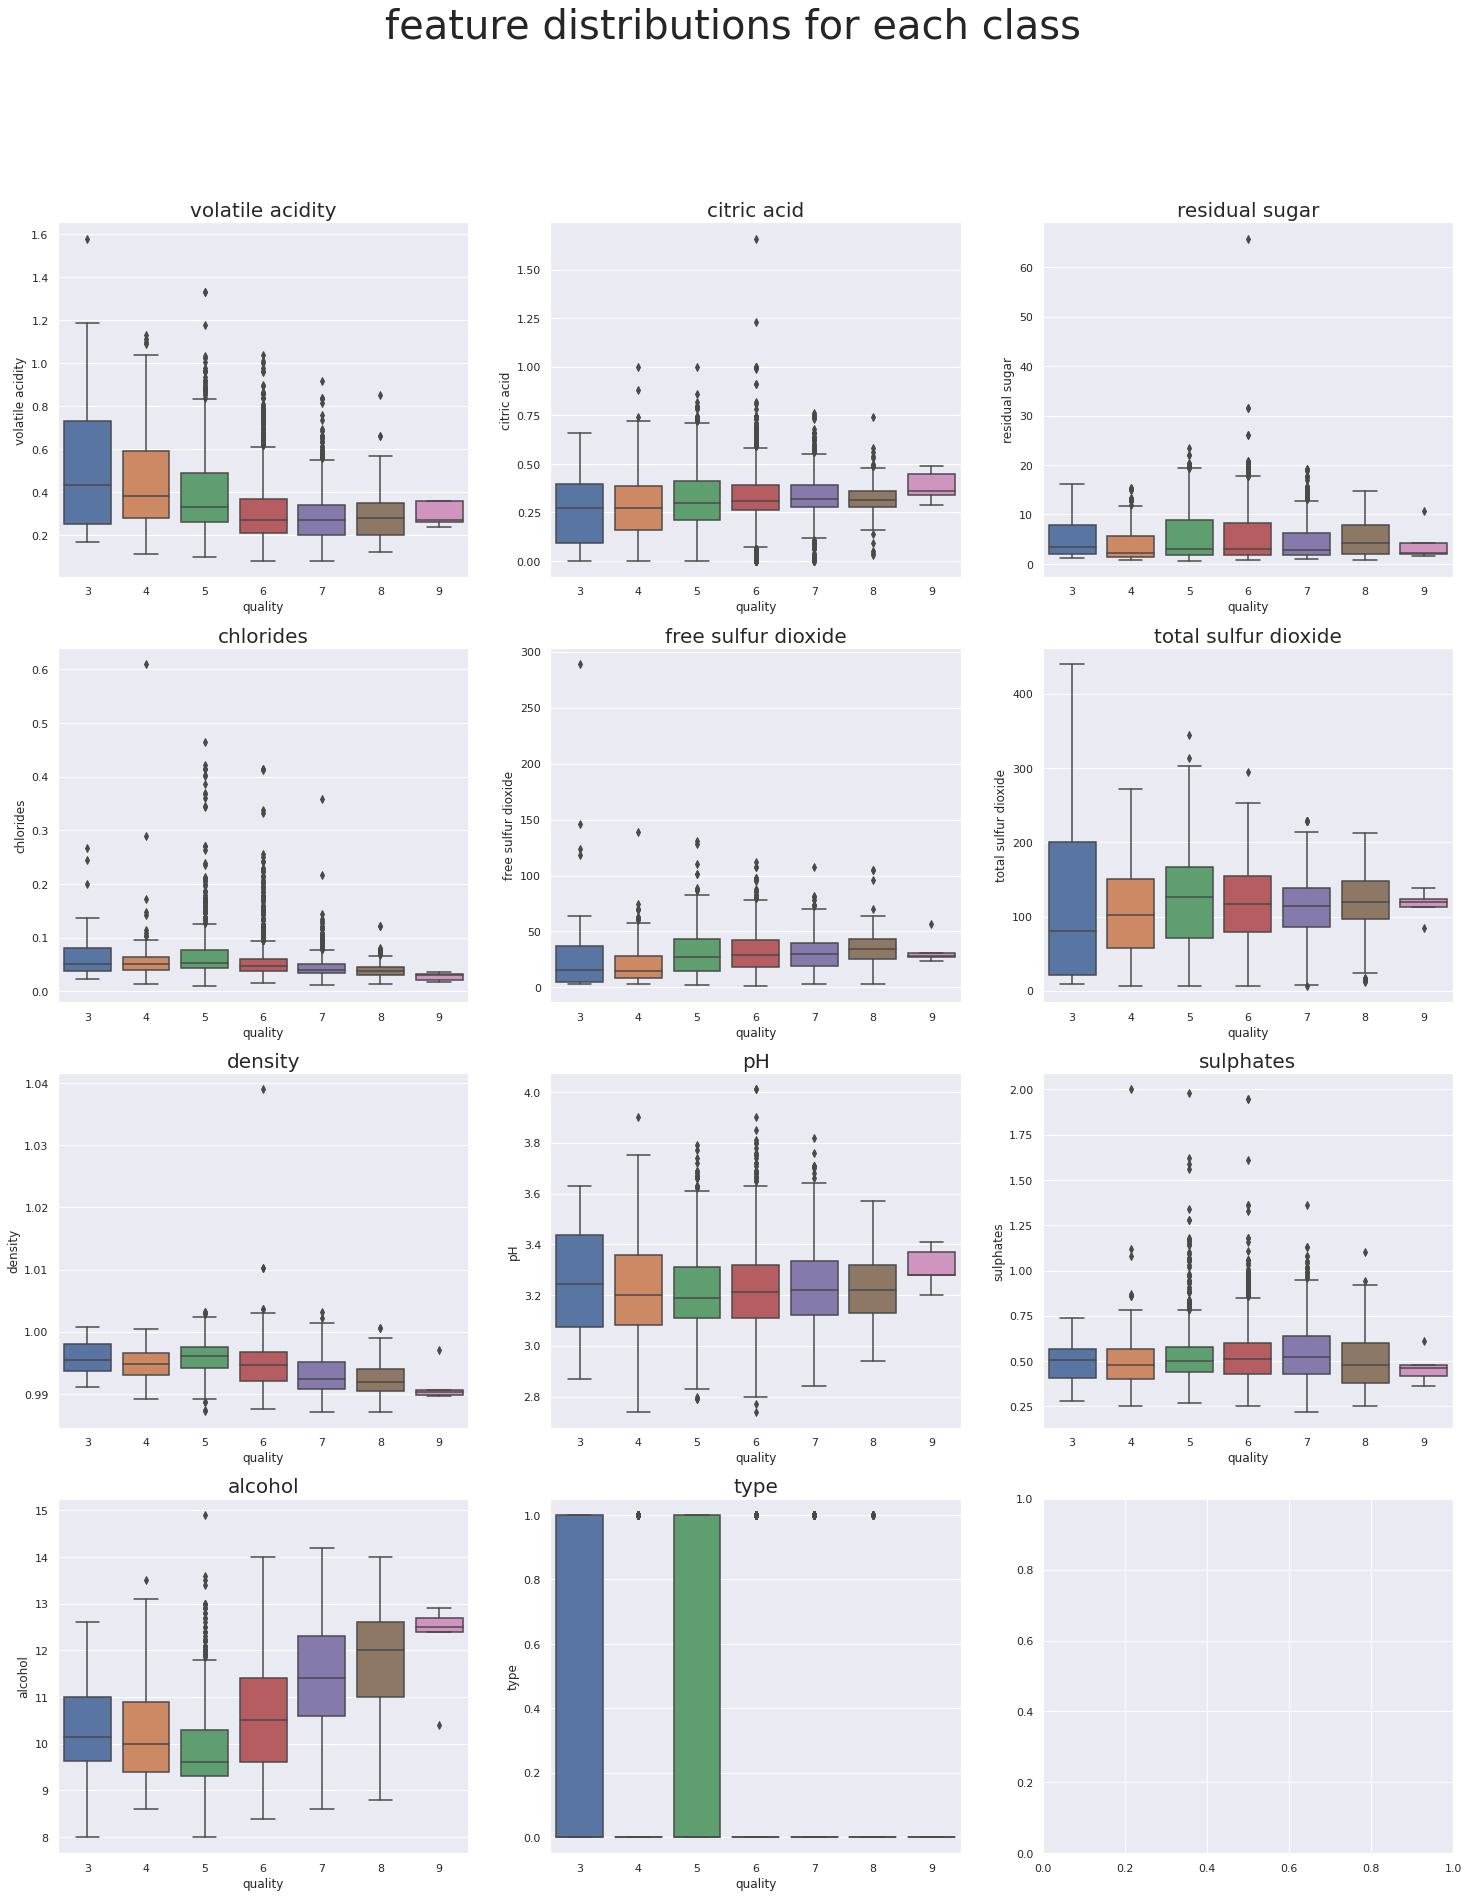

In [ ]:
fig, axes = plt.subplots(4, 3, figsize=(25, 30))

fig.suptitle('feature distributions for each class', fontsize = 40)
for ax, col in zip(axes.flat, train.columns[2:]):
  sns.boxplot(x='quality', y=col, ax=ax, data=train)
  ax.set_title(col, fontsize=20)
# plt.tight_layout()
plt.show()

Text(0.5, 0.98, 'feature distributions')

Text(0.5, 1.0, 'volatile acidity')

Text(0.5, 1.0, 'citric acid')

Text(0.5, 1.0, 'residual sugar')

Text(0.5, 1.0, 'chlorides')

Text(0.5, 1.0, 'free sulfur dioxide')

Text(0.5, 1.0, 'total sulfur dioxide')

Text(0.5, 1.0, 'density')

Text(0.5, 1.0, 'pH')

Text(0.5, 1.0, 'sulphates')

Text(0.5, 1.0, 'alcohol')

Text(0.5, 1.0, 'type')

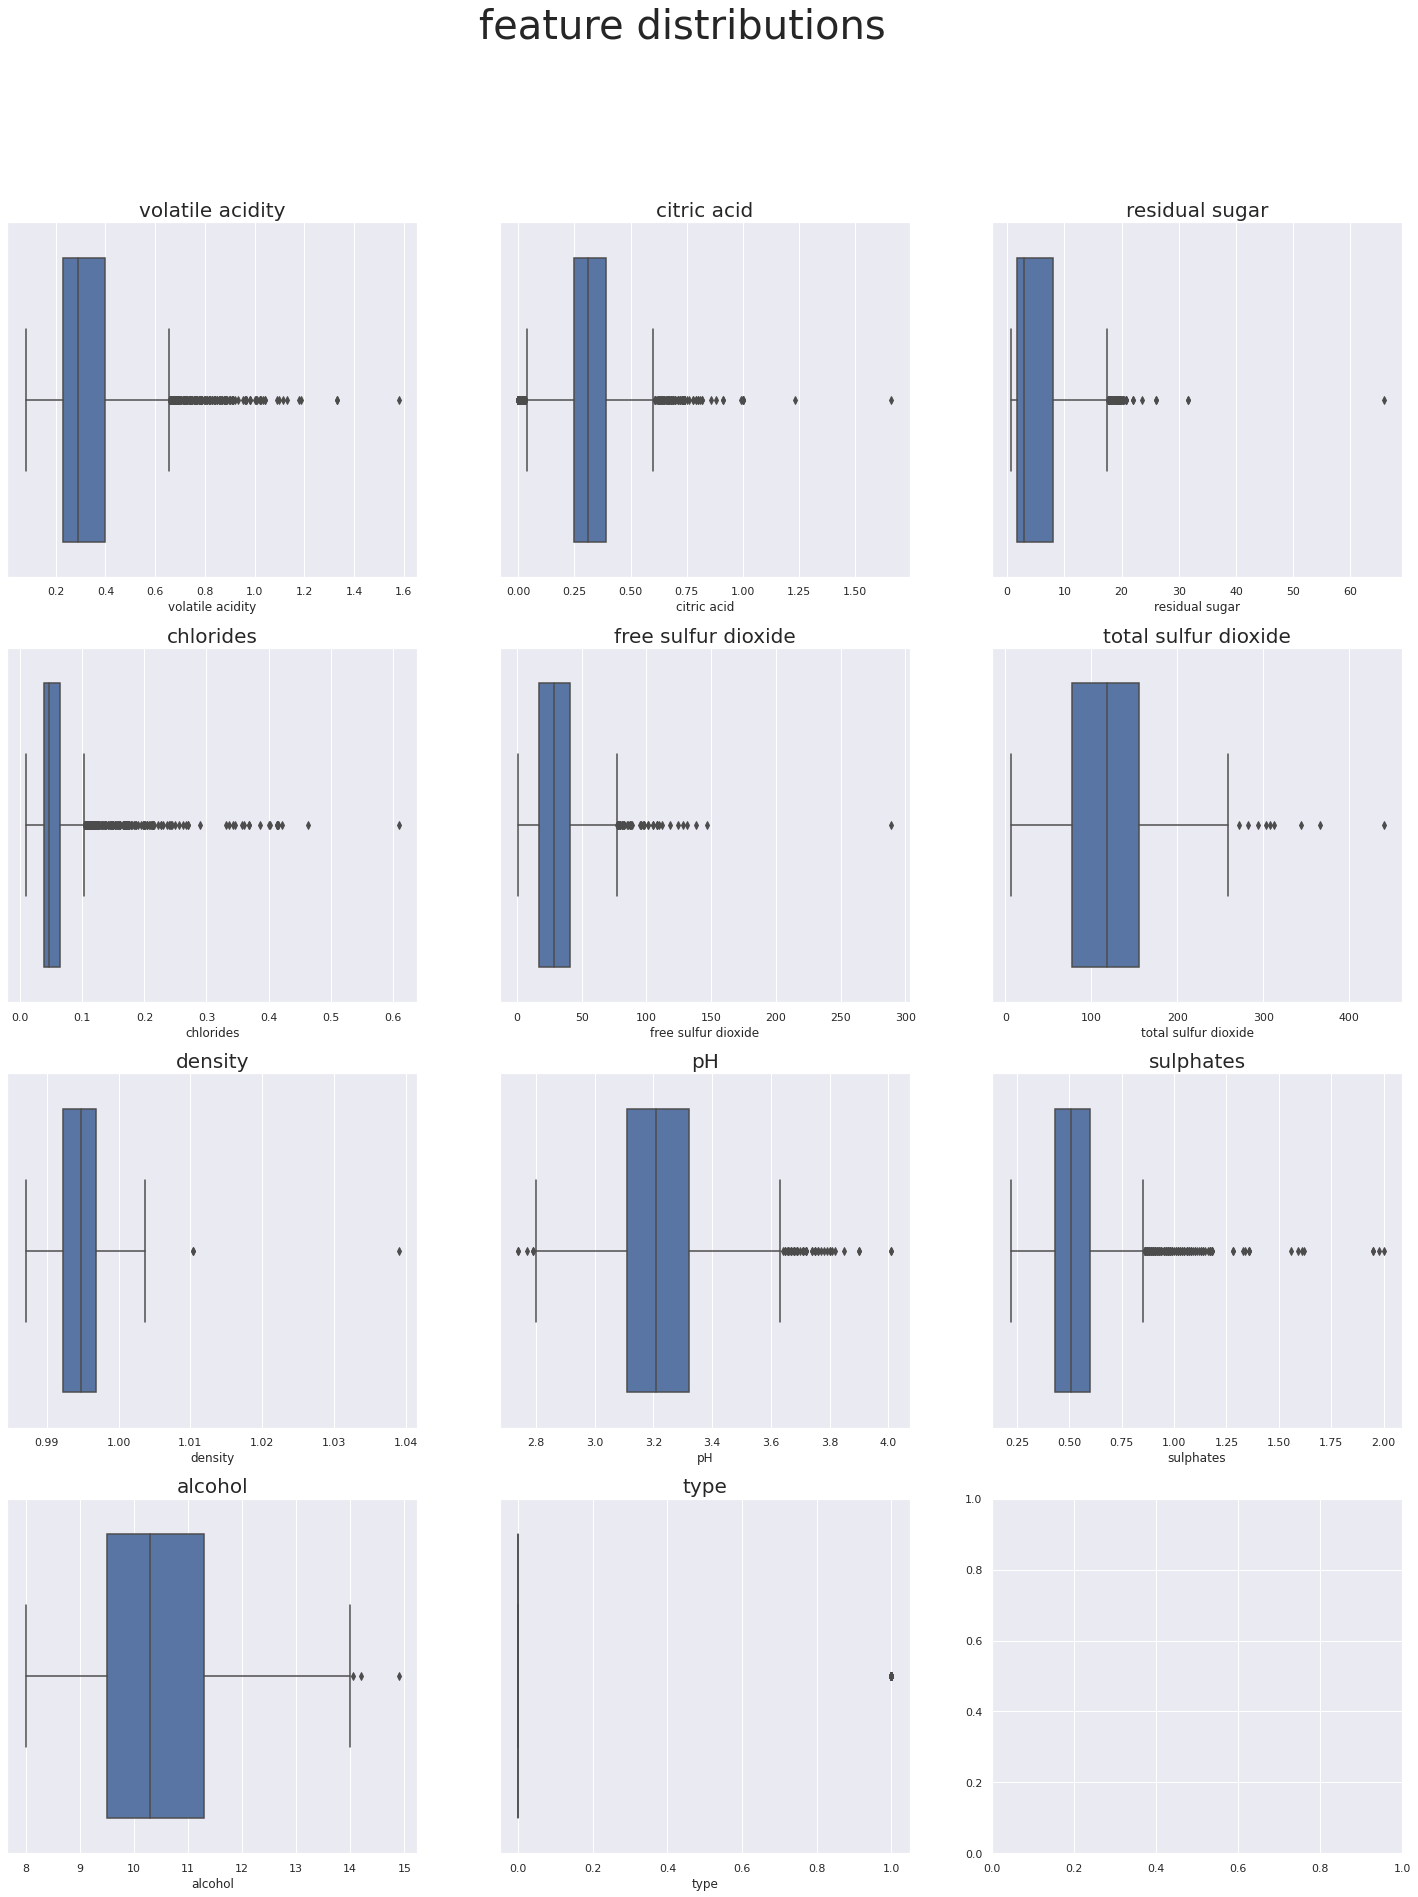

In [ ]:
fig, axes = plt.subplots(4, 3, figsize=(25, 30))

fig.suptitle('feature distributions', fontsize = 40)
for ax, col in zip(axes.flat, train.columns[2:]):
  sns.boxplot(train[col],ax=ax)
  ax.set_title(col, fontsize=20)
# plt.tight_layout()
plt.show()



*  일부 피처들에 이상치 존재 확인
*  density, total sulfur dioxide 제외한 대부분의 피처들에서 이상치 존재
*  특히, volatile acidity(휘발성산), citric acid(시트르산), chlorides(염화물), pH(수소이온농도), sulphates(황산염) 에서 많이 존재







In [ ]:
# 수치형 피처들의 비대칭도 확인

int_col = train.select_dtypes(exclude='object')	

for col in int_col:
    print('{:15}'.format(col), '{:.2f}'.format(train[col].skew()))

quality         0.16
fixed acidity   1.71
volatile acidity 1.50
citric acid     0.49
residual sugar  1.50
chlorides       5.19
free sulfur dioxide 1.31
total sulfur dioxide 0.00
density         0.60
pH              0.39
sulphates       1.92
alcohol         0.55
type            1.20




*   chlorides > sulphates > fixed acidity 순으로 비대칭성이 심함
*   total sulfur dioxide 은 이미 정규분포를 따르기 때문에 변환 진행 필요 없음






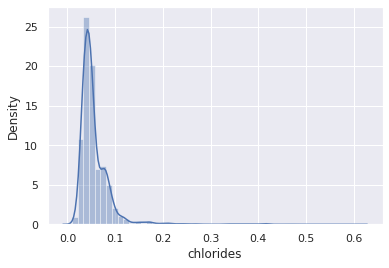

In [ ]:
# chlorides (비대칭성 가장 심함 = 이상치 많이 존재)

sns.distplot(train['chlorides'])

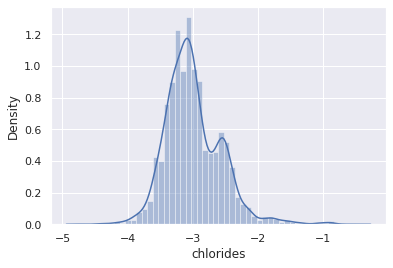

In [ ]:
# 로그 변환 진행


log_chlorides = np.log(train['chlorides'])
sns.distplot(log_chlorides)
#train['chlorides'] = log_chlorides
#sns.distplot(train['chlorides'])

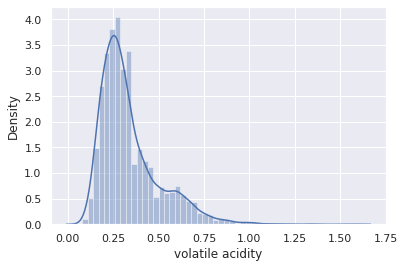

In [ ]:
# volatile acidity

sns.distplot(train['volatile acidity'])

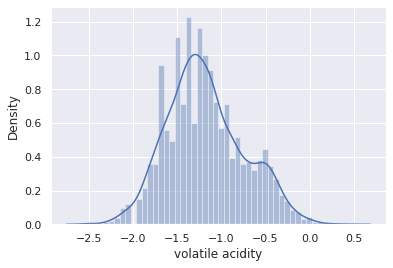

In [ ]:
# 로그 변환 진행


log_volatileacidity = np.log(train['volatile acidity'])
sns.distplot(log_volatileacidity)

In [ ]:
# 로그 변환 필요한 피처들 모두 로그 변환 진행
# 수치에 0이 존재하는 피처들은 로그 변환이 불가하기 때문에 제곱근 변환으로 대체하여 진행

cols = ['chlorides','volatile acidity','fixed acidity', 'citric acid','residual sugar', 'free sulfur dioxide',
        'density', 'pH', 'sulphates', 'alcohol']

for i in cols:
  if (train[i].min()==0): 
    train[i] = np.sqrt(train[i]) 
  else:
    train[i] = np.log(train[i])

In [ ]:
# 변환 완료

train.head(10)

quality  fixed acidity  volatile acidity  citric acid  residual sugar  \
index                                                                          
0            5       1.722767         -0.363843     0.244949        1.916923   
1            5       2.174752         -0.494296     0.374166        0.875469   
2            5       2.066863         -1.560648     0.624500        0.693147   
3            6       1.945910         -1.560648     0.556776        1.791759   
4            6       2.054124         -0.916291     0.509902        2.251292   
5            6       1.791759         -1.660731     0.608276        2.272126   
6            5       1.808289         -1.514128     0.700000        0.405465   
7            6       1.960095         -0.967584     0.648074        2.468100   
8            5       1.916923         -1.427116     0.556776        2.906901   
9            5       1.916923         -0.941609     0.591608        2.451005   

       chlorides  free sulfur dioxide  total sulfur dioxide   density  \
index                                                                   
0      -3.170086             2.197225                  84.0 -0.005696   
1      -2.703063             2.302585                  42.0 -0.003105   
2      -2.864704             3.044522                 138.0 -0.008274   
3      -3.079114             3.367296                 108.0 -0.006119   
4      -2.830218             3.465736                 178.0 -0.004510   
5      -3.442019             2.833213                  50.0 -0.006823   
6      -2.975930             2.890372                  87.0 -0.007226   
7      -3.194183             3.465736                 193.0 -0.003767   
8      -3.079114             3.688879                 142.0  0.000000   
9      -3.123566             4.043051                 220.0 -0.002253   

             pH  sulphates   alcohol  type  
index                                       
0      1.235471  -0.820981  2.322388     0  
1      1.160021  -0.527633  2.251292     1  
2      1.115142  -0.653926  2.388763     0  
3      1.181727  -0.693147  2.379546     0  
4      1.111858  -0.843970  2.388763     0  
5      1.124930  -0.415515  2.484907     0  
6      1.193922  -0.776529  2.261763     0  
7      1.111858  -0.713350  2.302585     0  
8      1.193922  -0.891598  2.163323     0  
9      1.121678  -0.634878  2.230014     0

Text(0.5, 0.98, 'feature distributions')

Text(0.5, 1.0, 'volatile acidity')

Text(0.5, 1.0, 'citric acid')

Text(0.5, 1.0, 'residual sugar')

Text(0.5, 1.0, 'chlorides')

Text(0.5, 1.0, 'free sulfur dioxide')

Text(0.5, 1.0, 'total sulfur dioxide')

Text(0.5, 1.0, 'density')

Text(0.5, 1.0, 'pH')

Text(0.5, 1.0, 'sulphates')

Text(0.5, 1.0, 'alcohol')

Text(0.5, 1.0, 'type')

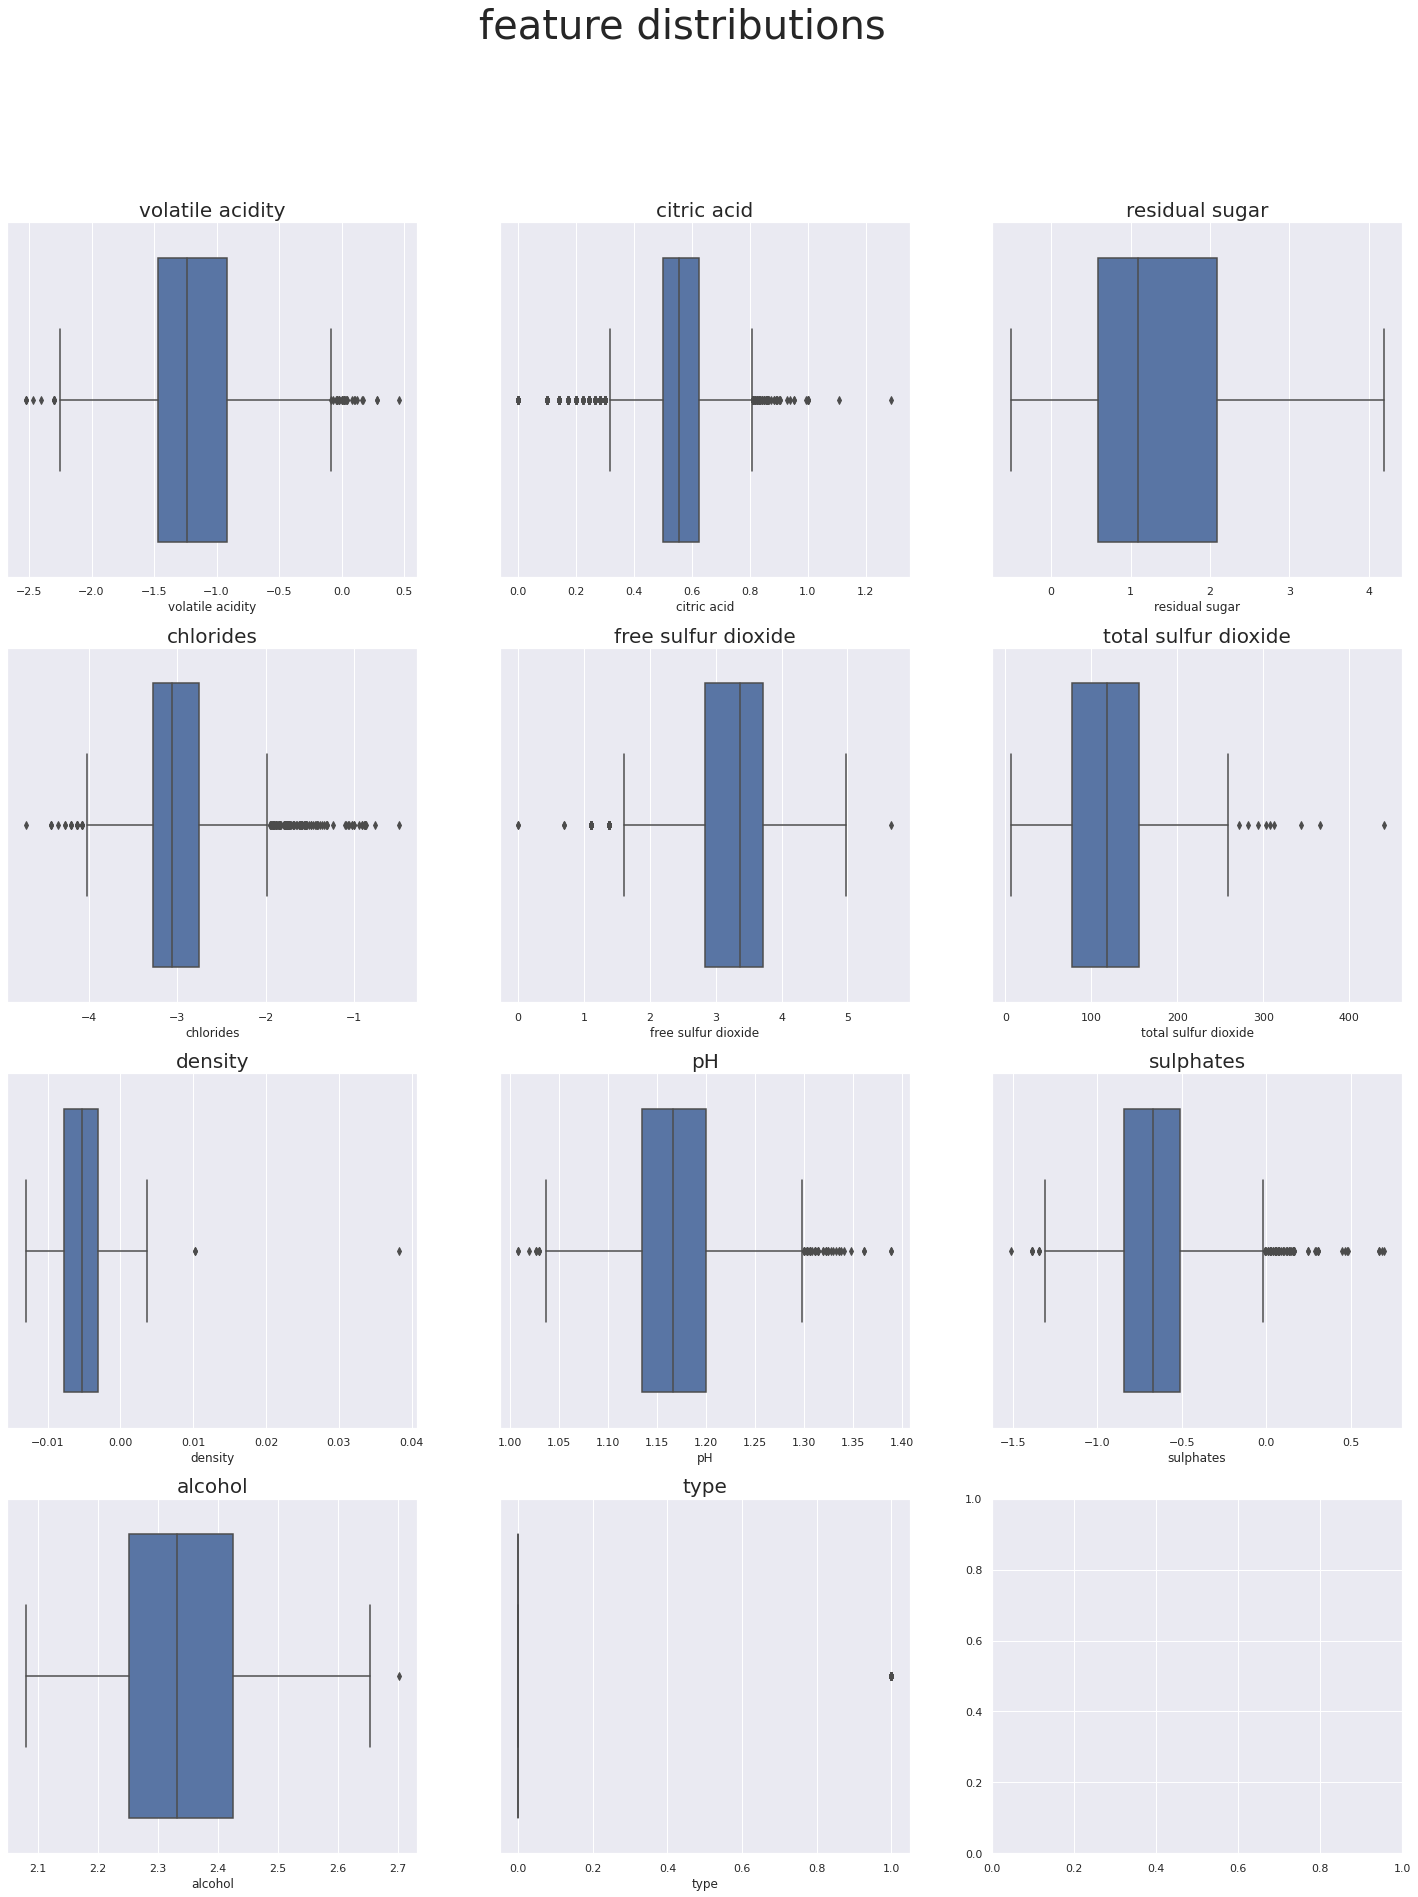

In [ ]:
fig, axes = plt.subplots(4, 3, figsize=(25, 30))

fig.suptitle('feature distributions', fontsize = 40)
for ax, col in zip(axes.flat, train.columns[2:]):
  sns.boxplot(train[col],ax=ax)
  ax.set_title(col, fontsize=20)
# plt.tight_layout()
plt.show()



*   이상치 많이 줄어든 것 확인 가능하지만 여전히 이상치 존재



# **3.2.1 Standardization scaler 를 이용한 2차 이상치 제거**




*  **Scaling**; 특성의 스케일 문제, 피처들 간의 단위가 다르기 때문에 단위 통일 필요
*  예를 들어, density (0.98-1.03) alcohol (8-15) 단위 사이에는 엄연한 차이가 존재
*  이를 적절히 처리해 주지 않으면 모델이 학습에 어려움을 겪게 될 위험 증가







In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

In [ ]:
s_scaler = StandardScaler()
m_scaler = MinMaxScaler()

In [ ]:
df = train.drop(['quality','type'],axis=1)
cols = df.columns
train[cols].head(5)

fixed acidity  volatile acidity  citric acid  residual sugar  \
index                                                                 
0           1.722767         -0.363843     0.244949        1.916923   
1           2.174752         -0.494296     0.374166        0.875469   
2           2.066863         -1.560648     0.624500        0.693147   
3           1.945910         -1.560648     0.556776        1.791759   
4           2.054124         -0.916291     0.509902        2.251292   

       chlorides  free sulfur dioxide  total sulfur dioxide   density  \
index                                                                   
0      -3.170086             2.197225                  84.0 -0.005696   
1      -2.703063             2.302585                  42.0 -0.003105   
2      -2.864704             3.044522                 138.0 -0.008274   
3      -3.079114             3.367296                 108.0 -0.006119   
4      -2.830218             3.465736                 178.0 -0.004510   

             pH  sulphates   alcohol  
index                                 
0      1.235471  -0.820981  2.322388  
1      1.160021  -0.527633  2.251292  
2      1.115142  -0.653926  2.388763  
3      1.181727  -0.693147  2.379546  
4      1.111858  -0.843970  2.388763

In [ ]:
# Scaling 진행

t_data = s_scaler.fit_transform(df)
train[cols]=t_data
train.head(5)

quality  fixed acidity  volatile acidity  citric acid  residual sugar  \
index                                                                          
0            5      -1.458882          1.875542    -1.928347        0.685140   
1            5       1.304131          1.577194    -1.091892       -0.521499   
2            5       0.644599         -0.861575     0.528588       -0.732739   
3            6      -0.094792         -0.861575     0.090196        0.540125   
4            6       0.566725          0.612083    -0.213235        1.072544   

       chlorides  free sulfur dioxide  total sulfur dioxide   density  \
index                                                                   
0      -0.408961            -1.458765             -0.560852 -0.115861   
1       0.676778            -1.307548             -1.307080  0.740197   
2       0.300993            -0.242694              0.398583 -0.967481   
3      -0.197469             0.220562             -0.134436 -0.255430   
4       0.381167             0.361847              1.109276  0.275945   

             pH  sulphates   alcohol  type  
index                                       
0      1.360528  -0.594763 -0.207983     0  
1     -0.160712   0.547618 -0.846158     1  
2     -1.065572   0.055794  0.387816     0  
3      0.276932  -0.096943  0.305085     0  
4     -1.131786  -0.684291  0.387816     0

Text(0.5, 0.98, 'feature distributions')

Text(0.5, 1.0, 'volatile acidity')

Text(0.5, 1.0, 'citric acid')

Text(0.5, 1.0, 'residual sugar')

Text(0.5, 1.0, 'chlorides')

Text(0.5, 1.0, 'free sulfur dioxide')

Text(0.5, 1.0, 'total sulfur dioxide')

Text(0.5, 1.0, 'density')

Text(0.5, 1.0, 'pH')

Text(0.5, 1.0, 'sulphates')

Text(0.5, 1.0, 'alcohol')

Text(0.5, 1.0, 'type')

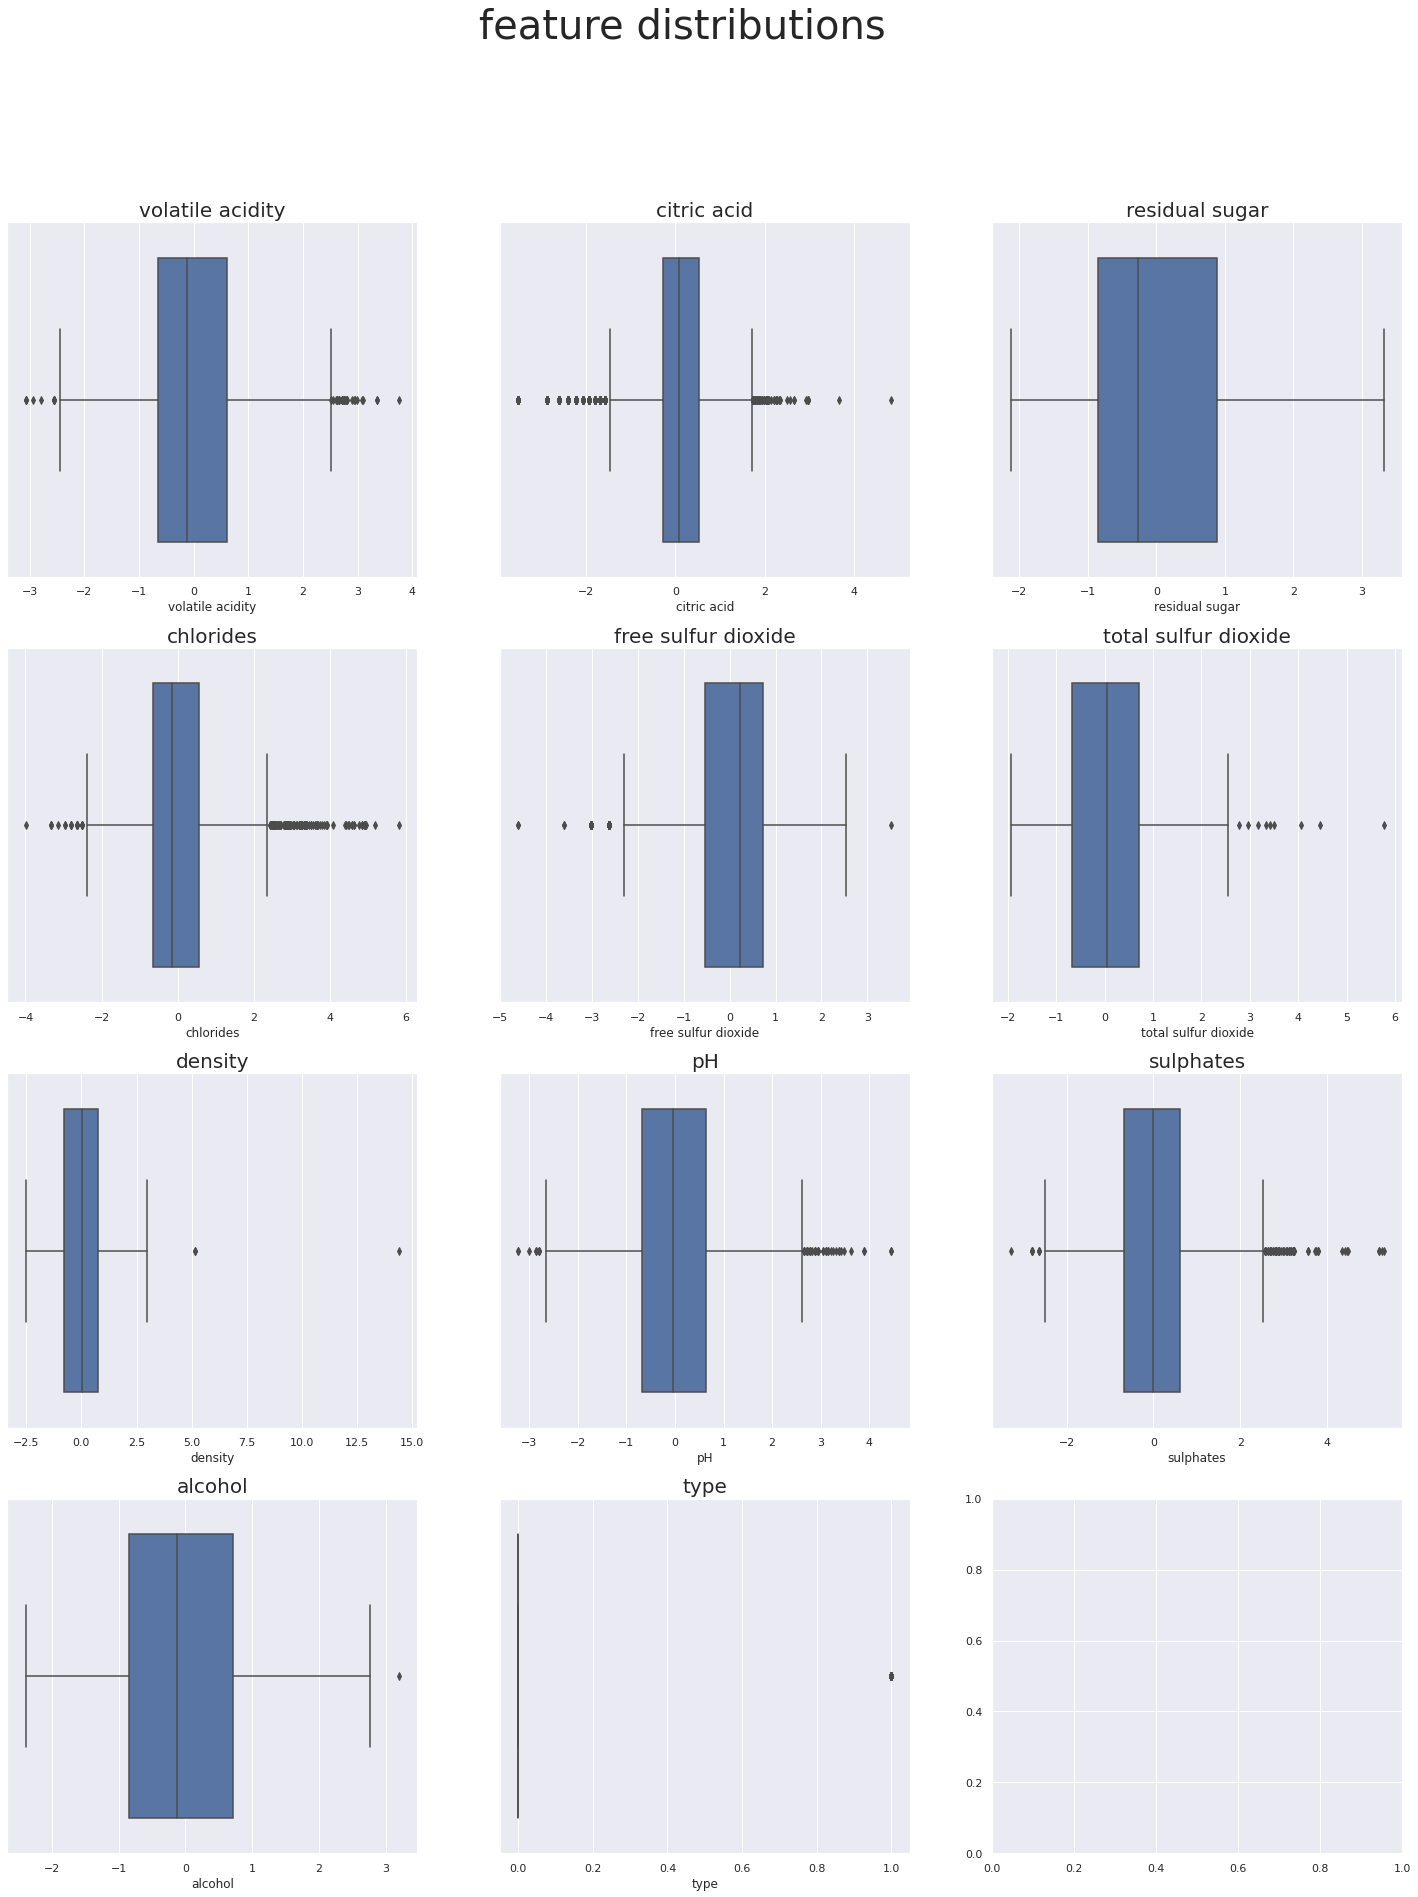

In [ ]:
fig, axes = plt.subplots(4, 3, figsize=(25, 30))

fig.suptitle('feature distributions', fontsize = 40)
for ax, col in zip(axes.flat, train.columns[2:]):
  sns.boxplot(train[col],ax=ax)
  ax.set_title(col, fontsize=20)
# plt.tight_layout()
plt.show()



*   처음 boxplot 과 비교하였을 때, 이상치 많이 줄어들었음 확인 가능
*   그러나, chlorides, citric acid 을 비롯한 일부 항목들에는 여전히 눈에 띠는 이상치 존재




# **3.2.2 기준 설정을 통한 3차 이상치 제거**


*  표준편차 커질수록, 이상치일 가능성 증가
*  보통은 **3SD**를 기준으로 하여, -3SD>관측값 or 3SD<관측값 인 경우 해당 관측값을 이상치로 판단
*   해당 모델에서도 3SD를 기준으로 이상치 제거 진행




In [ ]:
before = len(train)

train[cols] = np.where(abs(t_data) > 3.0, np.nan, t_data)
train = train.dropna()

after = len(train)

before, after

(5497, 5130)



*   367개의 데이터가 이상치로 판단되어 drop



Text(0.5, 0.98, 'feature distributions')

Text(0.5, 1.0, 'volatile acidity')

Text(0.5, 1.0, 'citric acid')

Text(0.5, 1.0, 'residual sugar')

Text(0.5, 1.0, 'chlorides')

Text(0.5, 1.0, 'free sulfur dioxide')

Text(0.5, 1.0, 'total sulfur dioxide')

Text(0.5, 1.0, 'density')

Text(0.5, 1.0, 'pH')

Text(0.5, 1.0, 'sulphates')

Text(0.5, 1.0, 'alcohol')

Text(0.5, 1.0, 'type')

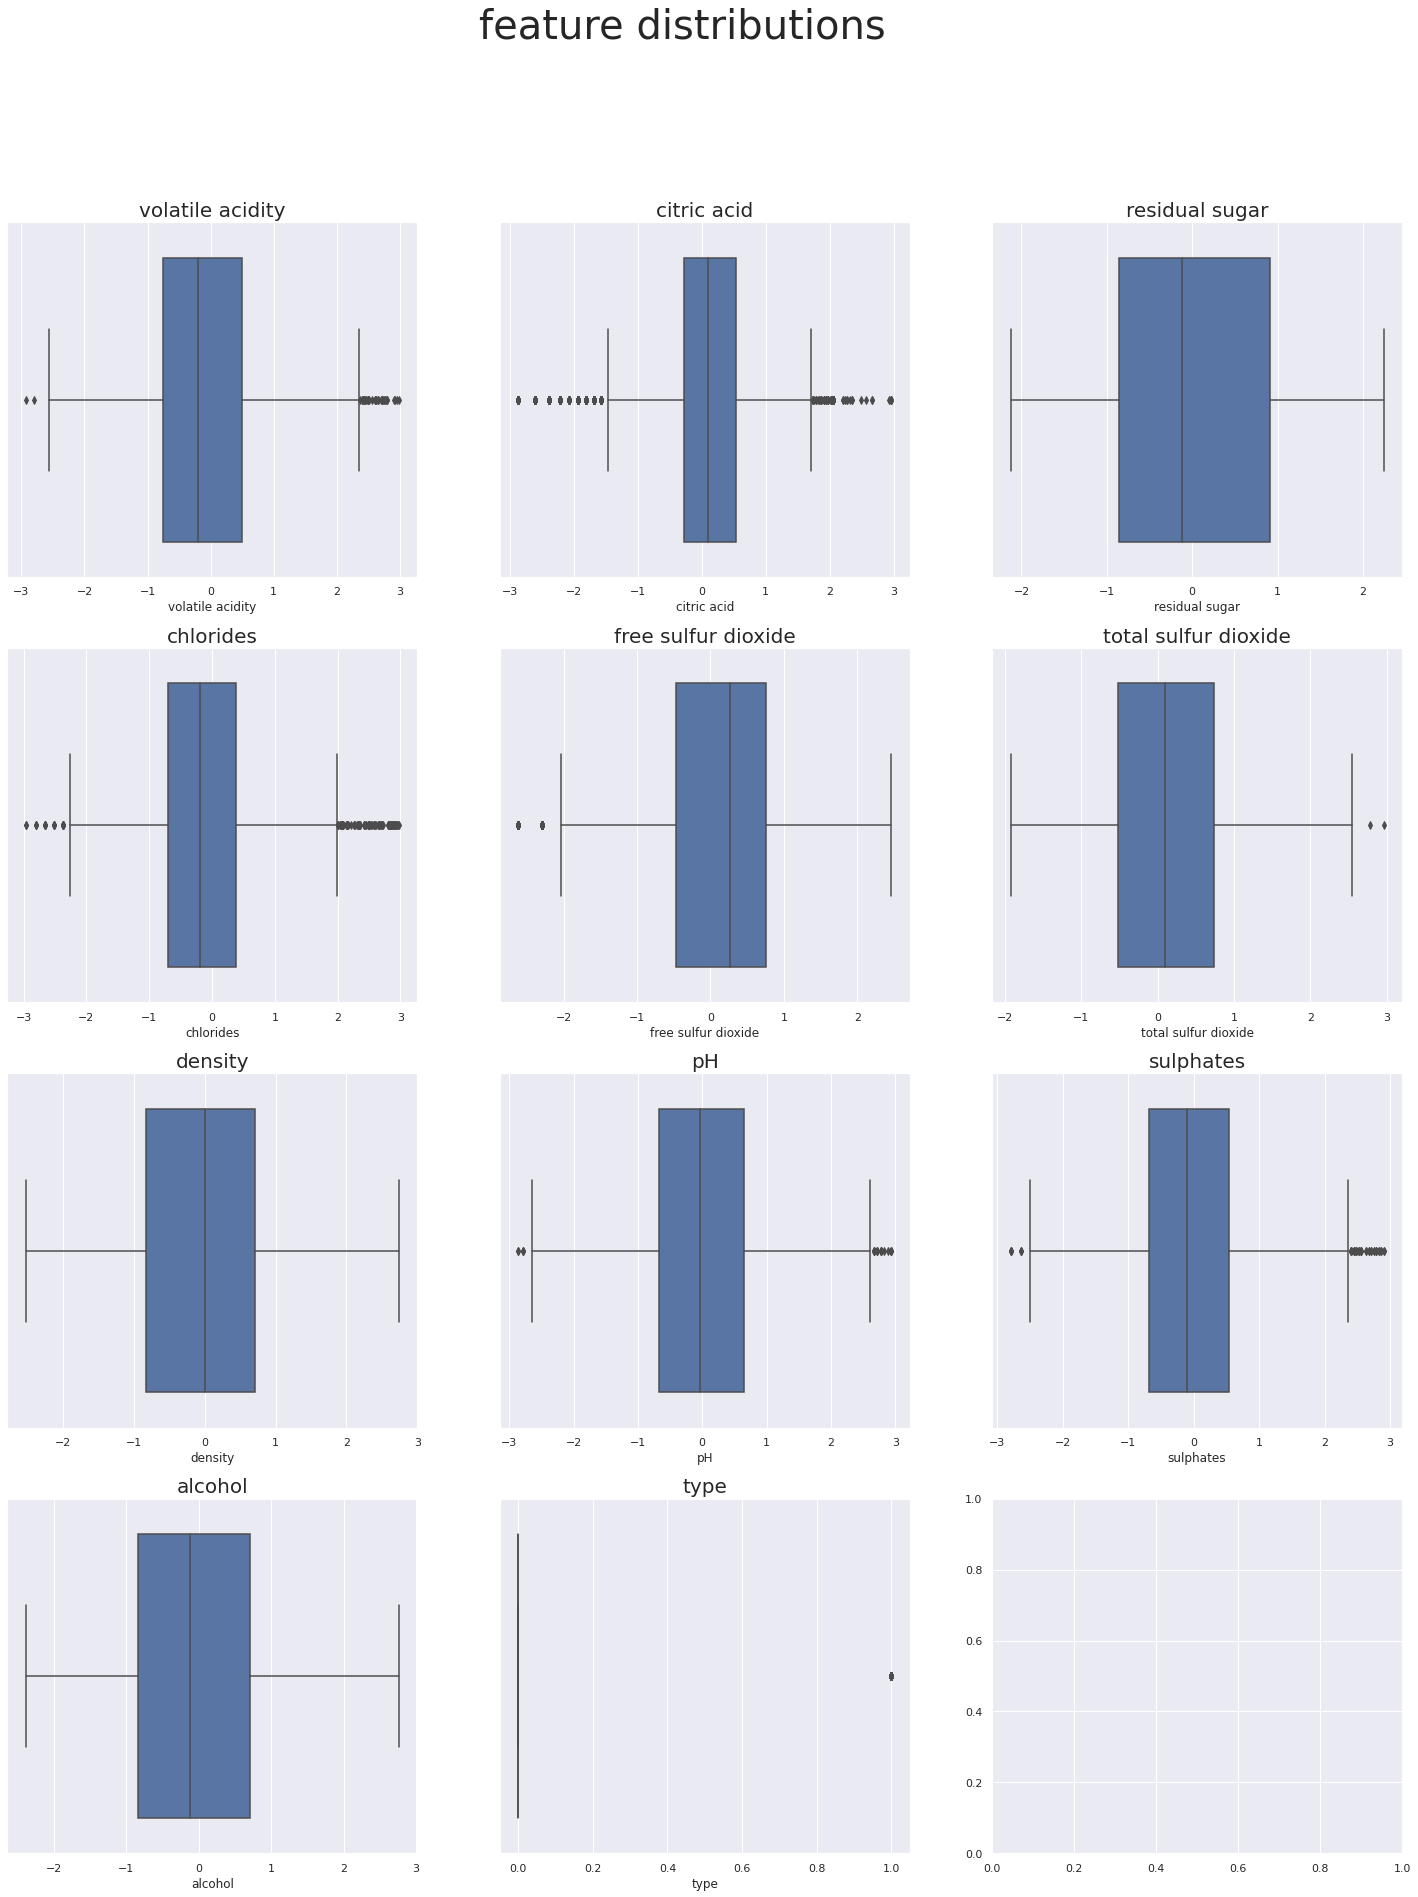

In [ ]:
fig, axes = plt.subplots(4, 3, figsize=(25, 30))

fig.suptitle('feature distributions', fontsize = 40)
for ax, col in zip(axes.flat, train.columns[2:]):
  sns.boxplot(train[col],ax=ax)
  ax.set_title(col, fontsize=20)
# plt.tight_layout()
plt.show()



*   처음에 비해 훨씬 정리된 boxplot 확인 가능



Text(0.5, 0.98, 'feature distributions for each class')

Text(0.5, 1.0, 'volatile acidity')

Text(0.5, 1.0, 'citric acid')

Text(0.5, 1.0, 'residual sugar')

Text(0.5, 1.0, 'chlorides')

Text(0.5, 1.0, 'free sulfur dioxide')

Text(0.5, 1.0, 'total sulfur dioxide')

Text(0.5, 1.0, 'density')

Text(0.5, 1.0, 'pH')

Text(0.5, 1.0, 'sulphates')

Text(0.5, 1.0, 'alcohol')

Text(0.5, 1.0, 'type')

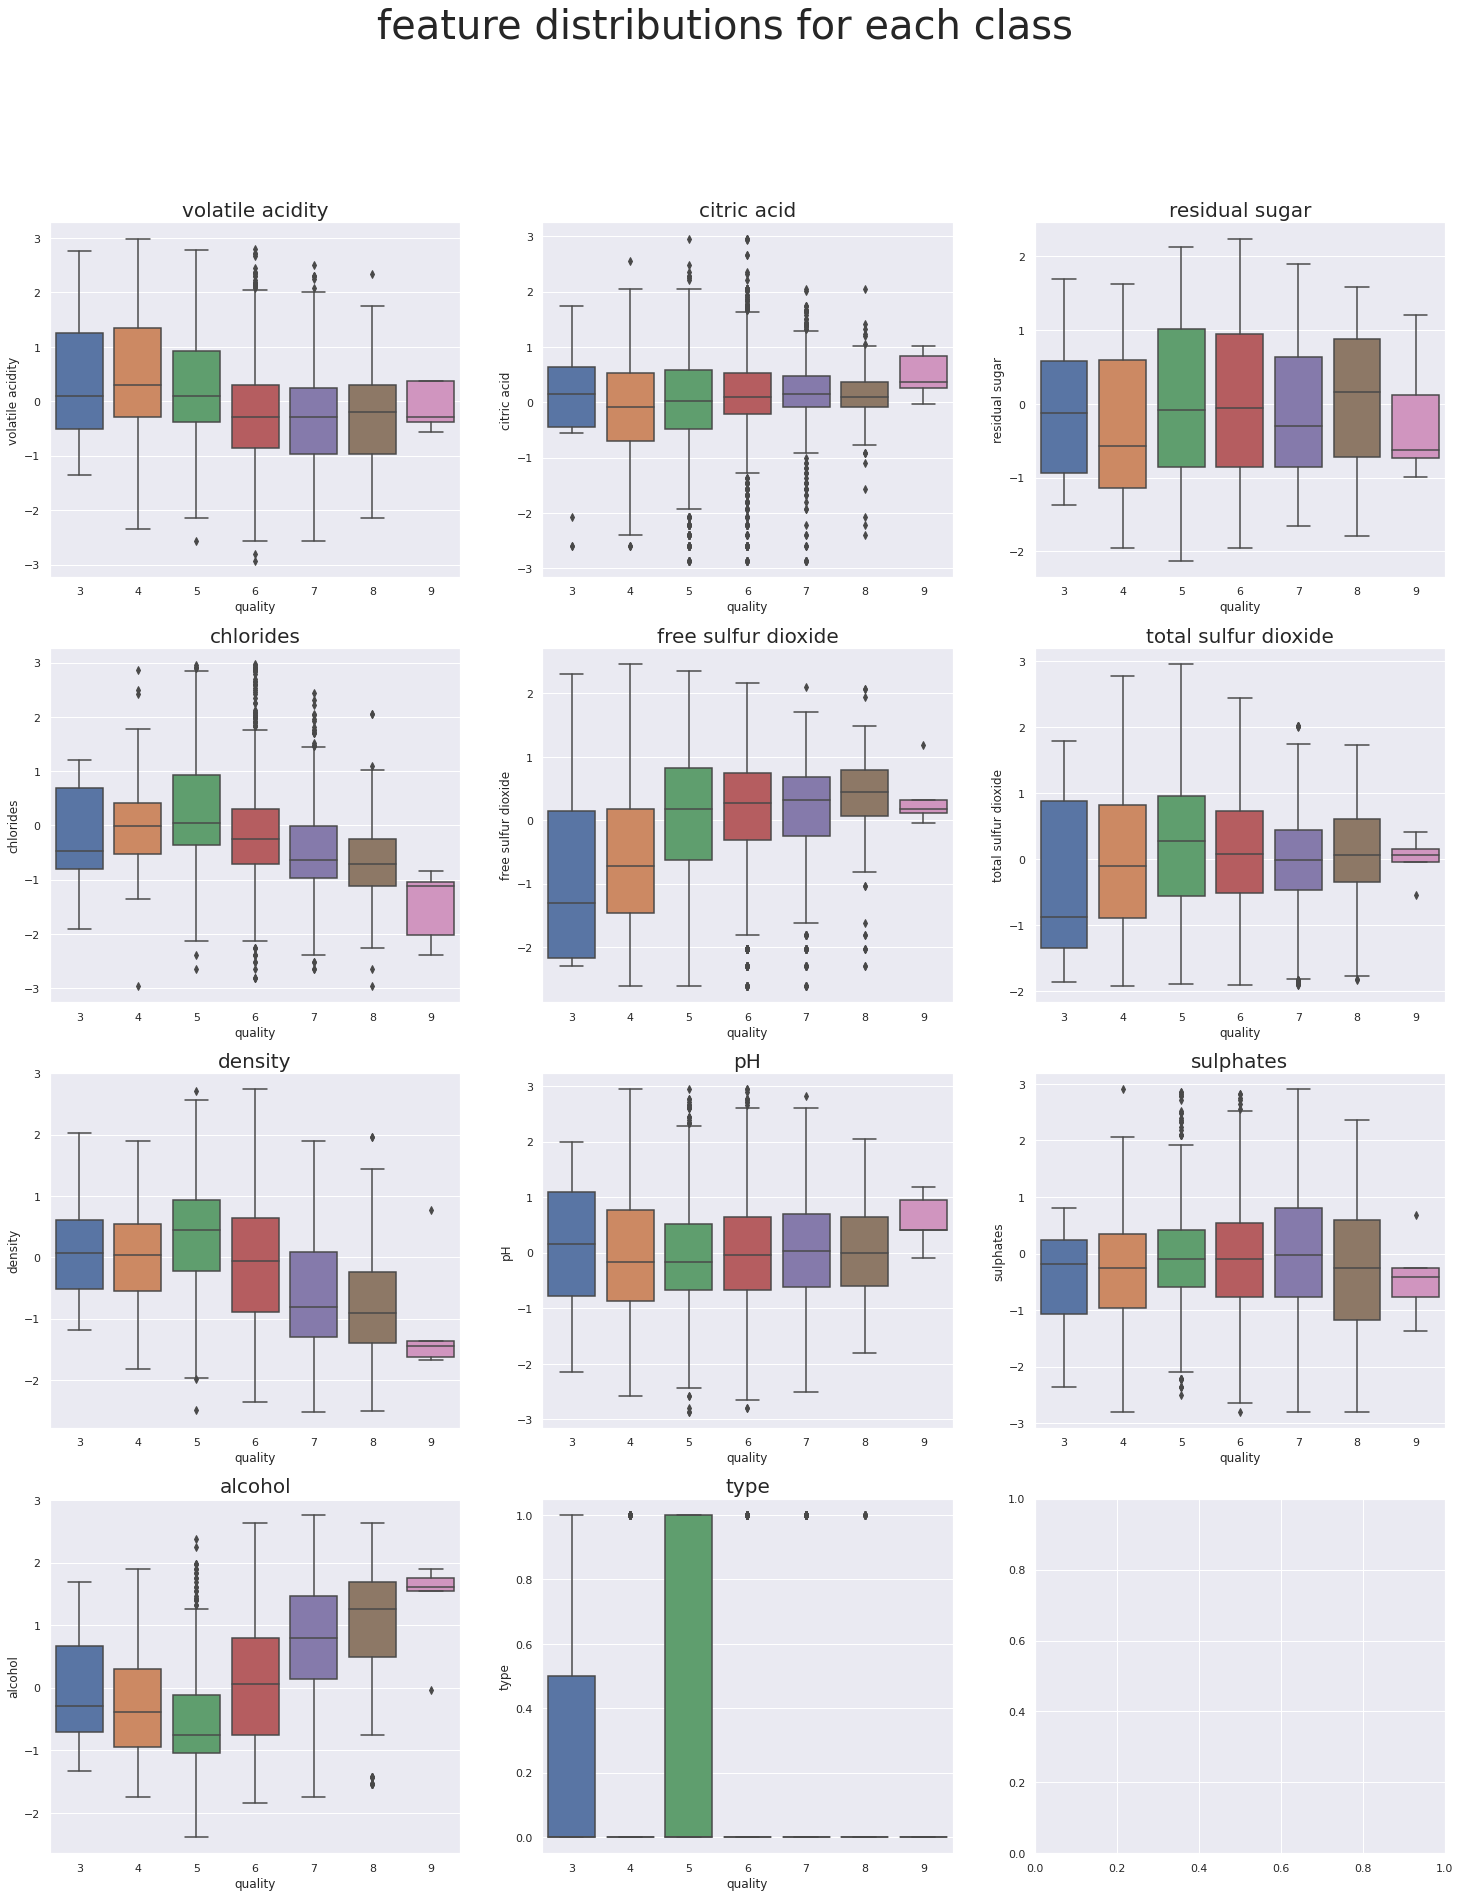

In [ ]:
# quality 별로 확인

fig, axes = plt.subplots(4, 3, figsize=(25, 30))

fig.suptitle('feature distributions for each class', fontsize = 40)
for ax, col in zip(axes.flat, train.columns[2:]):
  sns.boxplot(x='quality', y=col, ax=ax, data=train)
  ax.set_title(col, fontsize=20)
# plt.tight_layout()
plt.show()

# **3.2.3 test data 에도 Scaling 진행**

In [ ]:
df = test.drop(['type'],axis=1)
cols = df.columns
test[cols].head(5)
t_data = s_scaler.fit_transform(df)
test[cols]=t_data
test.head(5)

fixed acidity  volatile acidity  citric acid  residual sugar  \
index                                                                 
0                9.0              0.31         0.48             6.6   
1               13.3              0.43         0.58             1.9   
2                6.5              0.28         0.27             5.2   
3                7.2              0.15         0.39             1.8   
4                6.8              0.26         0.26             2.0   

       chlorides  free sulfur dioxide  total sulfur dioxide  density    pH  \
index                                                                        
0          0.043                 11.0                  73.0  0.99380  2.90   
1          0.070                 15.0                  40.0  1.00040  3.06   
2          0.040                 44.0                 179.0  0.99480  3.19   
3          0.043                 21.0                 159.0  0.99480  3.52   
4          0.019                 23.5                  72.0  0.99041  3.16   

       sulphates  alcohol  
index                      
0           0.38     11.6  
1           0.49      9.0  
2           0.69      9.4  
3           0.47     10.0  
4           0.47     11.8

fixed acidity  volatile acidity  citric acid  residual sugar  \
index                                                                 
0           1.306951         -0.220579     1.098184        0.236865   
1           4.507070          0.477272     1.780836       -0.749722   
2          -0.553583         -0.395042    -0.335387       -0.057012   
3          -0.032634         -1.151046     0.483796       -0.770714   
4          -0.330319         -0.511350    -0.403653       -0.728731   

       chlorides  free sulfur dioxide  total sulfur dioxide   density  \
index                                                                   
0      -0.385503            -1.108531             -0.756734 -0.352060   
1       0.343645            -0.888114             -1.327873  1.915724   
2      -0.466520             0.709907              1.077835 -0.008456   
3      -0.385503            -0.557489              0.731690 -0.008456   
4      -1.033635            -0.419728             -0.774041 -1.516876   

             pH  sulphates   alcohol  type  
index                                       
0     -1.943080  -1.068114  1.000172     0  
1     -0.949812  -0.311854 -1.203025     1  
2     -0.142782   1.063164 -0.864071     0  
3      1.905833  -0.449356 -0.355641     0  
4     -0.329020  -0.449356  1.169649     0

# **3.3_ Up-sampling; 타깃변수 Quality의 데이터 비대칭성 해결**



*   이상치만 제거한 상태에서 예측 진행할 경우 모델은 3, 9 의 품질을 예측하지 못하고 대부분 5~7 의 품질로만 예측
*   5~7 클래스와 비교하였을때, 이 외의 클래스 데이터가 부족하여 훈련 제대로 진행되지 못했기 때문
*   타깃변수에서의 **data imbalance** 문제 해결 필요
*   **Up-sampling**; 
    1. 적은 비율을 가진 Class에 대해 2배의 샘플을 추가하는 것 
    2. Train Set 에서만 Up-Sampling 진행 주의
    3. 동일한 데이터를 복사하는 것이기 때문에 overfitting 발생 위험









<Figure size 936x720 with 0 Axes>

Text(0.5, 1.0, 'Quailty')

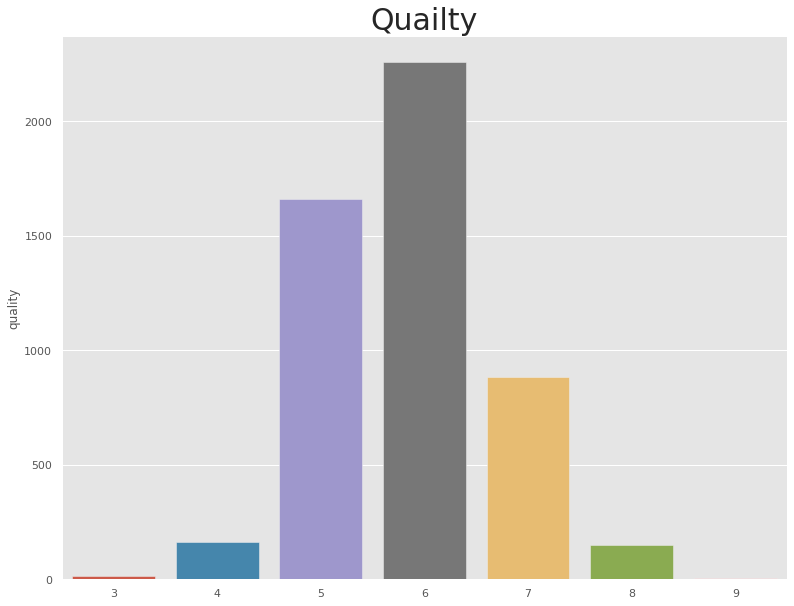

In [ ]:
count = train['quality'].value_counts()
plt.style.use('ggplot')
plt.figure(figsize=(13,10))
plt.title('Quailty',fontsize=30)
sns.barplot(x=count.index, y=count)

In [ ]:
before = len(train)


train = train.append(train[train['quality'].isin([3, 4, 8, 9])]) # 3, 4, 8, 9 클래스 데이터 복사하여 한번 더 저장


after = len(train)
before, after

(5130, 5461)



*   331개의 데이터 증가



<Figure size 936x720 with 0 Axes>

Text(0.5, 1.0, 'Quailty')

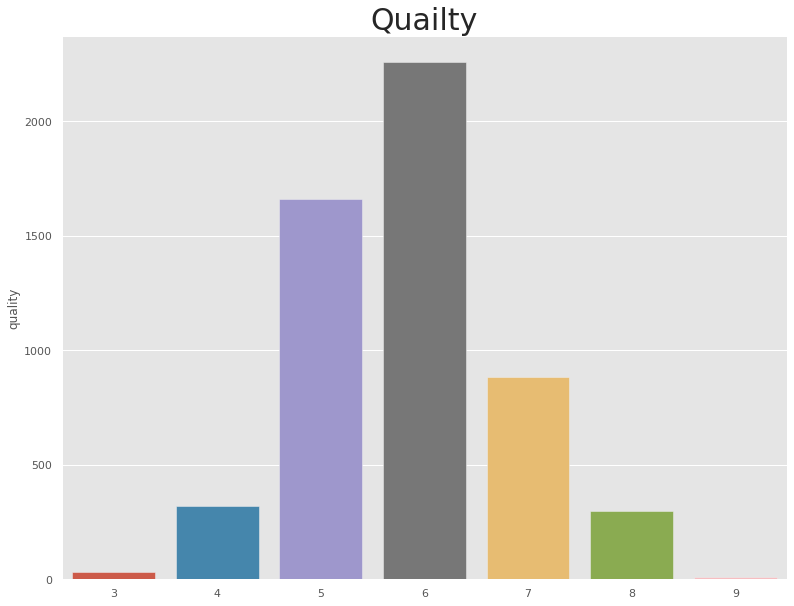

In [ ]:
count = train['quality'].value_counts()
plt.style.use('ggplot')
plt.figure(figsize=(13,10))
plt.title('Quailty',fontsize=30)
sns.barplot(x=count.index, y=count)



*   여전히 3,9 클래스의 데이터가 많이 부족하다고 판단하여 복사 한번 더 진행



In [ ]:
train = train.append(train[train['quality'].isin([3, 9])]) # 3, 4, 8, 9 클래스 데이터 복사하여 한번 더 저장

<Figure size 936x720 with 0 Axes>

Text(0.5, 1.0, 'Quailty')

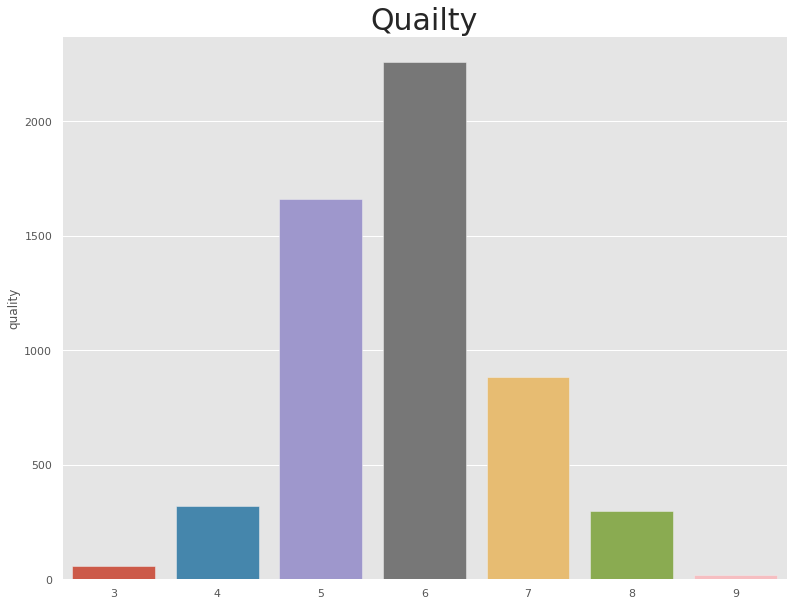

In [ ]:
count = train['quality'].value_counts()
plt.style.use('ggplot')
plt.figure(figsize=(13,10))
plt.title('Quailty',fontsize=30)
sns.barplot(x=count.index, y=count)

# **4. Modeling & Validation**

# **4.0_ import Library**

In [ ]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from lightgbm import LGBMClassifier
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.model_selection import train_test_split, KFold, cross_validate, cross_val_score, GridSearchCV # k-fold 교차검증

In [ ]:
X = train.drop(columns=['quality'])
Y = train['quality']

In [ ]:
X.head(1)

fixed acidity  volatile acidity  citric acid  residual sugar  \
index                                                                 
0          -1.458882          1.875542    -1.928347         0.68514   

       chlorides  free sulfur dioxide  total sulfur dioxide   density  \
index                                                                   
0      -0.408961            -1.458765             -0.560852 -0.115861   

             pH  sulphates   alcohol  type  
index                                       
0      1.360528  -0.594763 -0.207983     0

# **4.1_ Kfold validation**

In [ ]:
kfold = KFold(n_splits=5)
random_state=100
models = [] 



*   **분류 문제에 많이 활용되는 모델들 정확도 평가 진행**
*   XGBClassifier, LGBMClassifier, LogisticRegression, SVC, GaussianNB,Perceptron, KNN, RandomForestClassifier, GradientBoostingClassifier





In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size=0.25,random_state=7)

In [ ]:
models.append(XGBClassifier(silent=True,random_state = random_state))

In [ ]:
models.append(LGBMClassifier(verbose_eval=False,random_state = random_state))

In [ ]:
models.append(LogisticRegression(solver='liblinear',random_state = random_state))

In [ ]:
models.append(SVC())

In [ ]:
models.append(GaussianNB())

In [ ]:
models.append(Perceptron(random_state = random_state))

In [ ]:
models.append(KNN())

In [ ]:
models.append(RandomForestClassifier(random_state = random_state))

In [ ]:
models.append(GradientBoostingClassifier(random_state = random_state))

In [ ]:
scores = []
i = 0
for model in models:
  scores.append(round(np.mean(cross_val_score(model, X, Y,scoring='accuracy', cv=5)),3))

In [ ]:
Model = ['XGBClassifier', 'LGBMClassifier','LogisticRegression','SVC','GaussianNB','Perceptron','KNN', 'RandomForestClassifier','GradientBoostingClassifier']
pd.DataFrame({'Model':Model,'Accuracy':scores})

Model  Accuracy
0               XGBClassifier     0.570
1              LGBMClassifier     0.705
2          LogisticRegression     0.510
3                         SVC     0.544
4                  GaussianNB     0.348
5                  Perceptron     0.383
6                         KNN     0.543
7      RandomForestClassifier     0.747
8  GradientBoostingClassifier     0.601



**정확도 측정 결과**


*   RandomForestClassifier, LGBMClassifier, GradientBoostingClassifier 모델이 비교적 높게 나옴
*   LogisticRegression 모델의 정확도가 생각보다 낮게 측정됨
*   정확도가 비교적 높게 나온 **RandomForestClassifier, LGBMClassifier, GradientBoostingClassifier** 모델들과 **LogisticRegression**, **XGBClassifier** 를 추가적으로 채택하여 하이퍼파라미터 튜닝 진행








# **4.2_ Hyperparameter Tuning & Score**



*   gridSearch/ManualSearch 튜닝 진행



# **4.2.0 F1 Score**




*   분류 모델에서 사용되는 머신러닝 평가지표
*   Precision 과 Recall 의 조화평균
*   Precision 과 Recall 이 어느 한 쪽으로 치우치지 않을 때 상대적으로 높은 값을 보임
*   0.0 ~ 1.0 사이의 값을 가지며 높을수록 좋음





In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report

# **4.2.1 RandomForestClassifier**

In [ ]:
model = RandomForestClassifier()
rf_param_grid = {
        'n_estimators' : [50,100,200,300],
        'max_depth' : [None, 5, 10, 15],
        'min_samples_leaf' : [8,12,18],
        'max_features': [0.4, 0.6, 0.8, 1] 
}
grid_rf = GridSearchCV(model,param_grid = rf_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)
grid_rf.fit(X,Y)
rf_best = grid_rf.best_estimator_

Fitting 5 folds for each of 192 candidates, totalling 960 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
             estimator=RandomForestClassifier(), n_jobs=4,
             param_grid={'max_depth': [None, 5, 10, 15],
                         'max_features': [0.4, 0.6, 0.8, 1],
                         'min_samples_leaf': [8, 12, 18],
                         'n_estimators': [50, 100, 200, 300]},
             scoring='accuracy', verbose=1)

In [ ]:
grid_rf.best_estimator_

RandomForestClassifier(max_features=0.6, min_samples_leaf=8, n_estimators=200)

In [ ]:
grid_rf.best_score_, grid_rf.best_params_

(0.601697960531748,
 {'max_depth': None,
  'max_features': 0.6,
  'min_samples_leaf': 8,
  'n_estimators': 200})

In [ ]:
classifier = RandomForestClassifier(max_depth= None,criterion='gini',max_features=0.4, min_samples_leaf=8, n_estimators=130,random_state=0,)
classifier.fit(X_train, y_train)

RandomForestClassifier(max_features=0.4, min_samples_leaf=8, n_estimators=130,
                       random_state=0)

In [ ]:
rf_best = classifier

In [ ]:
rf_pred = classifier.predict(X_test)

In [ ]:
rf_acc = accuracy_score(y_test, rf_pred)
rf_prec = round(precision_score(y_test, rf_pred,average='micro'),ndigits=3)
rf_rec = round(recall_score(y_test, rf_pred,average='micro'),ndigits=3)
rf_recall = round(recall_score(y_test,rf_pred,average='micro'),ndigits=3)
rf_f1 = round(f1_score(y_test, rf_pred,average='micro'),ndigits=3)
rf_recall, rf_f1

(0.586, 0.586)

In [ ]:
rfresults = pd.DataFrame([['RandomForestClassifier', rf_acc, rf_prec, rf_recall, rf_f1]],
               columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1Score'])
rfresults

Model  Accuracy  Precision  Recall  F1Score
0  RandomForestClassifier  0.586483      0.586   0.586    0.586




*   F1 Score 0.586
*   gridSearch 진행한 결과로 훈련한 점수가 만족스럽지 않아서 Manual Search 로 훈련 한번 더 진행



In [ ]:
classifier = RandomForestClassifier(n_estimators=200, criterion='gini', random_state=500)
classifier.fit(X_train, y_train)
pred_rf = classifier.predict(X_test)
Y_compare_rfc = pd.DataFrame({'Actual' : y_test, 'Predicted' : pred_rf})

RandomForestClassifier(n_estimators=200, random_state=500)

In [ ]:
rf_best = classifier

In [ ]:
rff_acc = accuracy_score(y_test, pred_rf)
rff_prec = round(precision_score(y_test, pred_rf,average='micro'),ndigits=3)
rff_rec = round(recall_score(y_test, pred_rf,average='micro'),ndigits=3)
rff_recall = round(recall_score(y_test,pred_rf,average='micro'),ndigits=3)
rff_f1 = round(f1_score(y_test, pred_rf,average='micro'),ndigits=3)
rff_recall, rff_f1

(0.725, 0.725)

In [ ]:
rffresults = pd.DataFrame([['RandomForestClassifier', rff_acc, rff_prec, rff_recall, rff_f1]],
               columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1Score'])
rffresults

Model  Accuracy  Precision  Recall  F1Score
0  RandomForestClassifier  0.724564      0.725   0.725    0.725

*   F1 Score 0.725

In [ ]:
pd.DataFrame(classifier.feature_importances_, 
             index=X_train.columns, 
             columns=["f_Importances"]).sort_values(by="f_Importances", ascending=False)

f_Importances
alcohol                    0.123270
density                    0.098350
volatile acidity           0.097725
total sulfur dioxide       0.090175
free sulfur dioxide        0.087932
chlorides                  0.087774
residual sugar             0.086899
sulphates                  0.085318
pH                         0.083223
citric acid                0.079613
fixed acidity              0.075887
type                       0.003833


*   alcohol > density > volatile acidity 순으로 예측에 중요하게 작용



# **4.2.2 LGBMClassifier**

In [ ]:
model = LGBMClassifier()
lgb_param_grid ={
    'learning_rate': [1,0.1,0.01,0.001],
    'n_estimators': [50, 100, 200, 500], 
    'max_depth': [1,10,20],
    'num_leaves': [2, 500, 1000],
    'min_split_gain': [0.3, 0.4]
}
grid_lgbm = GridSearchCV(model,param_grid = lgb_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)
grid_lgbm.fit(X, Y)
lgbm_best = grid_lgbm.best_estimator_

Fitting 5 folds for each of 288 candidates, totalling 1440 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
             estimator=LGBMClassifier(), n_jobs=4,
             param_grid={'learning_rate': [1, 0.1, 0.01, 0.001],
                         'max_depth': [1, 10, 20], 'min_split_gain': [0.3, 0.4],
                         'n_estimators': [50, 100, 200, 500],
                         'num_leaves': [2, 500, 1000]},
             scoring='accuracy', verbose=1)

In [ ]:
grid_lgbm.best_score_, grid_lgbm.best_params_

(0.7109625959871192,
 {'learning_rate': 0.01,
  'max_depth': 20,
  'min_split_gain': 0.3,
  'n_estimators': 500,
  'num_leaves': 500})

In [ ]:
classifier = LGBMClassifier(learning_rate = 0.01,max_depth=20, min_split_gain=0.3, num_leaves=500,n_estimators = 500)
classifier.fit(X_train, y_train)

LGBMClassifier(learning_rate=0.01, max_depth=20, min_split_gain=0.3,
               n_estimators=500, num_leaves=500)

In [ ]:
lgbm_pred = classifier.predict(X_test)

In [ ]:
lgbm_acc = accuracy_score(y_test, lgbm_pred)
lgbm_prec = round(precision_score(y_test, lgbm_pred,average='micro'),ndigits=3)
lgbm_rec = round(recall_score(y_test, lgbm_pred,average='micro'),ndigits=3)
lgbm_recall = round(recall_score(y_test,lgbm_pred,average='micro'),ndigits=3)
lgbm_f1 = round(f1_score(y_test, lgbm_pred,average='micro'),ndigits=3)
lgbm_recall, lgbm_f1

(0.688, 0.688)

In [ ]:
lgbmresults = pd.DataFrame([['LGBMClassifier', lgbm_acc, lgbm_prec, lgbm_recall, lgbm_f1]],
               columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1Score'])
lgbmresults

Model  Accuracy  Precision  Recall  F1Score
0  LGBMClassifier  0.688227      0.688   0.688    0.688


*   F1 Score 0.688
*   gridSearch 진행한 결과로 훈련한 점수가 만족스럽지 않아서 Manual Search 로 훈련 한번 더 진행

In [ ]:
classifier = LGBMClassifier(lambda_l1=0.0002203264276308159,
    lambda_l2=3.475142578821981,
    num_leaves=214,n_estimators = 500,
    feature_fraction=0.561199075573614,
    bagging_fraction=0.7457484231012714,
    bagging_freq=5,
    min_child_samples=7)
classifier.fit(X_train, y_train)

LGBMClassifier(bagging_fraction=0.7457484231012714, bagging_freq=5,
               feature_fraction=0.561199075573614,
               lambda_l1=0.0002203264276308159, lambda_l2=3.475142578821981,
               min_child_samples=7, n_estimators=500, num_leaves=214)

In [ ]:
lgbm_pred = classifier.predict(X_test)

In [ ]:
lgbm_best = classifier

In [ ]:
lgbm_acc = accuracy_score(y_test, lgbm_pred)
lgbm_prec = round(precision_score(y_test, lgbm_pred,average='micro'),ndigits=3)
lgbm_rec = round(recall_score(y_test, lgbm_pred,average='micro'),ndigits=3)
lgbm_recall = round(recall_score(y_test,lgbm_pred,average='micro'),ndigits=3)
lgbm_f1 = round(f1_score(y_test, lgbm_pred,average='micro'),ndigits=3)
lgbm_recall, lgbm_f1

(0.71, 0.71)

In [ ]:
lgbmresults = pd.DataFrame([['LGBMClassifier', lgbm_acc, lgbm_prec, lgbm_recall, lgbm_f1]],
               columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1Score'])
lgbmresults

Model  Accuracy  Precision  Recall  F1Score
0  LGBMClassifier  0.710029       0.71    0.71     0.71

# **4.2.3 GradientBoostingClassifier**

In [ ]:
model = GradientBoostingClassifier()
gb_param_grid = {
              'n_estimators' : [50,100,200,300],
              'learning_rate': [0.1, 0.05, 0.01],
              'max_depth' : [None, 5, 10, 15],
              'min_samples_leaf': [100,150],
              'max_features': [0.3, 0.1] 
              }
#neg_mean_squared_error
grid_gbc = GridSearchCV(model,param_grid = gb_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)
grid_gbc.fit(X,Y)
gbc_best = grid_gbc.best_estimator_
grid_gbc.best_score_

Fitting 5 folds for each of 192 candidates, totalling 960 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
             estimator=GradientBoostingClassifier(), n_jobs=4,
             param_grid={'learning_rate': [0.1, 0.05, 0.01],
                         'max_depth': [None, 5, 10, 15],
                         'max_features': [0.3, 0.1],
                         'min_samples_leaf': [100, 150],
                         'n_estimators': [50, 100, 200, 300]},
             scoring='accuracy', verbose=1)

0.713870035504913

In [ ]:
grid_gbc.best_score_, grid_gbc.best_params_

(0.713870035504913,
 {'learning_rate': 0.1,
  'max_depth': None,
  'max_features': 0.3,
  'min_samples_leaf': 100,
  'n_estimators': 300})

In [ ]:
classifier = GradientBoostingClassifier(learning_rate= 0.1, max_depth=None, max_features=0.3, min_samples_leaf=100, n_estimators=300)
classifier.fit(X_train, y_train)

GradientBoostingClassifier(max_depth=None, max_features=0.3,
                           min_samples_leaf=100, n_estimators=300)

In [ ]:
gbc_best = classifier

In [ ]:
gbc_pred = classifier.predict(X_test)

In [ ]:
gbc_acc = accuracy_score(y_test, gbc_pred)
gbc_prec = round(precision_score(y_test, gbc_pred,average='micro'),ndigits=3)
gbc_rec = round(recall_score(y_test, gbc_pred,average='micro'),ndigits=3)
gbc_recall = round(recall_score(y_test,gbc_pred,average='micro'),ndigits=3)
gbc_f1 = round(f1_score(y_test, gbc_pred,average='micro'),ndigits=3)
gbc_recall, gbc_f1

(0.697, 0.697)

In [ ]:
gbcresults = pd.DataFrame([['GradientBoostingClassifier',gbc_acc, gbc_prec, gbc_recall, gbc_f1]],
               columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1Score'])
gbcresults

Model  Accuracy  Precision  Recall  F1Score
0  GradientBoostingClassifier  0.696948      0.697   0.697    0.697

# **4.2.4 LogisticRegression**

In [ ]:
model = LogisticRegression()
solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l1','l2']
c_values = [50, 10, 1.0, 0.1, 0.01]

grid = dict(solver=solvers,penalty=penalty,C=c_values)
grid_lr = GridSearchCV(model,param_grid = grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)
grid_lr.fit(X,Y)
lr_best = grid_lr.best_estimator_

Fitting 5 folds for each of 30 candidates, totalling 150 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
             estimator=LogisticRegression(), n_jobs=4,
             param_grid={'C': [50, 10, 1.0, 0.1, 0.01], 'penalty': ['l1', 'l2'],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear']},
             scoring='accuracy', verbose=1)

In [ ]:
grid_lr.best_score_, grid_lr.best_params_

(0.5097184377838329, {'C': 50, 'penalty': 'l2', 'solver': 'newton-cg'})

In [ ]:
classifier = LogisticRegression(C= 50, penalty= 'l2', solver= 'newton-cg') #newton-cg
classifier.fit(X_train, y_train)

LogisticRegression(C=50, solver='newton-cg')

In [ ]:
lr_best = classifier

In [ ]:
lr_pred = classifier.predict(X_test)

In [ ]:
lr_acc = accuracy_score(y_test, lr_pred)
lr_prec = round(precision_score(y_test, lr_pred,average='micro'),ndigits=3)
lr_rec = round(recall_score(y_test, lr_pred,average='micro'),ndigits=3)
lr_recall = round(recall_score(y_test,lr_pred,average='micro'),ndigits=3)
lr_f1 = round(f1_score(y_test, lr_pred,average='micro'),ndigits=3)
lr_recall, lr_f1

(0.507, 0.507)

In [ ]:
lrresults = pd.DataFrame([['Logistic Regression', lr_acc, lr_prec, lr_recall, lr_f1]],
               columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1Score'])
lrresults

Model  Accuracy  Precision  Recall  F1Score
0  Logistic Regression  0.506541      0.507   0.507    0.507

# **4.2.6 XGBClassifier**

In [ ]:
model = XGBClassifier()
xgb_param_grid = {
        'learning_rate': [0.01, 0.1],
        'max_depth': [3, 5, 7, 10],
        'min_child_weight': [1, 3, 5],
        'subsample': [0.5, 0.7],
        'colsample_bytree': [0.5, 0.7],
        'n_estimators' : [100, 200, 500],
        'objective': ['reg:squarederror']
        }
grid_xgb = GridSearchCV(model,param_grid = xgb_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)
grid_xgb.fit(X,Y)
xgb_best = grid_xgb.best_estimator_
grid_xgb.best_score_

Fitting 5 folds for each of 288 candidates, totalling 1440 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
             estimator=XGBClassifier(), n_jobs=4,
             param_grid={'colsample_bytree': [0.5, 0.7],
                         'learning_rate': [0.01, 0.1],
                         'max_depth': [3, 5, 7, 10],
                         'min_child_weight': [1, 3, 5],
                         'n_estimators': [100, 200, 500],
                         'objective': ['reg:squarederror'],
                         'subsample': [0.5, 0.7]},
             scoring='accuracy', verbose=1)

0.7269587977871357

In [ ]:
grid_xgb.best_score_, grid_xgb.best_params_

(0.7269587977871357,
 {'colsample_bytree': 0.7,
  'learning_rate': 0.1,
  'max_depth': 7,
  'min_child_weight': 1,
  'n_estimators': 200,
  'objective': 'reg:squarederror',
  'subsample': 0.7})

In [ ]:
classifier = XGBClassifier(colsample_bytree=0.7,learning_rate=0.1,max_depth= 7,min_child_weight=1,n_estimators=200,objective='reg:squarederror',subsample =0.7)
classifier.fit(X_train, y_train)

XGBClassifier(colsample_bytree=0.7, max_depth=7, n_estimators=200,
              objective='multi:softprob', subsample=0.7)

In [ ]:
xgb_pred = classifier.predict(X_test)

In [ ]:
xgb_acc = accuracy_score(y_test, xgb_pred)
xgb_prec = round(precision_score(y_test, xgb_pred,average='micro'),ndigits=3)
xgb_rec = round(recall_score(y_test, xgb_pred,average='micro'),ndigits=3)
xgb_recall = round(recall_score(y_test,xgb_pred,average='micro'),ndigits=3)
xgb_f1 = round(f1_score(y_test, xgb_pred,average='micro'),ndigits=3)
xgb_recall, xgb_f1

(0.695, 0.695)

In [ ]:
xgbresults = pd.DataFrame([['XGBClassifier', xgb_acc, xgb_prec, xgb_recall, xgb_f1]],
               columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1Score'])
xgbresults

Model  Accuracy  Precision  Recall  F1Score
0  XGBClassifier  0.695494      0.695   0.695    0.695

*   F1 Score 0.695
*   gridSearch 진행한 결과로 훈련한 점수가 만족스럽지 않아서 Manual Search 로 훈련 한번 더 진행

In [ ]:
classifier = XGBClassifier(n_estimators=200,learning_rate=0.1,objective='reg:squarederror',booster='dart',subsample= 0.9,colsample_bytree= 0.8,max_depth= 9,min_child_weight=2,eta=0.09461378797342677,gamma=0.013649892385363422,
    grow_policy='lossguide',sample_type='weighted',normalize_type='forest')
classifier.fit(X_train, y_train)

XGBClassifier(booster='dart', colsample_bytree=0.8, eta=0.09461378797342677,
              gamma=0.013649892385363422, grow_policy='lossguide', max_depth=9,
              min_child_weight=2, n_estimators=200, normalize_type='forest',
              objective='multi:softprob', sample_type='weighted',
              subsample=0.9)

In [ ]:
xgb_pred = classifier.predict(X_test)

In [ ]:
xgb_best = classifier

In [ ]:
xgb_acc = accuracy_score(y_test, xgb_pred)
xgb_prec = round(precision_score(y_test, xgb_pred,average='micro'),ndigits=3)
xgb_rec = round(recall_score(y_test, xgb_pred,average='micro'),ndigits=3)
xgb_recall = round(recall_score(y_test,xgb_pred,average='micro'),ndigits=3)
xgb_f1 = round(f1_score(y_test, xgb_pred,average='micro'),ndigits=3)
xgb_recall, xgb_f1

(0.706, 0.706)

In [ ]:
xgbresults = pd.DataFrame([['XGBClassifier', xgb_acc, xgb_prec, xgb_recall, xgb_f1]],
               columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1Score'])
xgbresults

Model  Accuracy  Precision  Recall  F1Score
0  XGBClassifier  0.706395      0.706   0.706    0.706

# **5 Application/Prediction**

In [ ]:
test_Logr = pd.Series(lr_best.predict(test),name='Logr')
test_GBC = pd.Series(gbc_best.predict(test), name="GBC")
test_RF = pd.Series(rf_best.predict(test), name="RF")
test_LGB = pd.Series(lgbm_best.predict(test), name="LGB")
test_XGB = pd.Series(xgb_best.predict(test), name="XGB")

In [ ]:
test_Logr.value_counts()

6    590
5    324
7     74
4      8
8      3
3      1
Name: Logr, dtype: int64

In [ ]:
test_GBC.value_counts()

6    482
5    384
7    123
4      6
8      5
Name: GBC, dtype: int64

In [ ]:
test_RF.value_counts()

6    538
5    358
7     96
4      5
8      3
Name: RF, dtype: int64

In [ ]:
test_LGB.value_counts()

6    516
5    377
7     97
4      5
8      5
Name: LGB, dtype: int64

In [ ]:
test_XGB.value_counts()

6    527
5    363
7     98
4      9
8      3
Name: XGB, dtype: int64

In [ ]:
F1results = pd.concat([rffresults,lgbmresults,gbcresults,lrresults,xgbresults], axis=0)
F1results.index = F1results.Model
F1results.drop('Model',axis=1)

Accuracy  Precision  Recall  F1Score
Model                                                           
RandomForestClassifier      0.724564      0.725   0.725    0.725
LGBMClassifier              0.710029      0.710   0.710    0.710
GradientBoostingClassifier  0.696948      0.697   0.697    0.697
Logistic Regression         0.506541      0.507   0.507    0.507
XGBClassifier               0.706395      0.706   0.706    0.706

Text(0.5, 1.0, 'Classification Model Results')

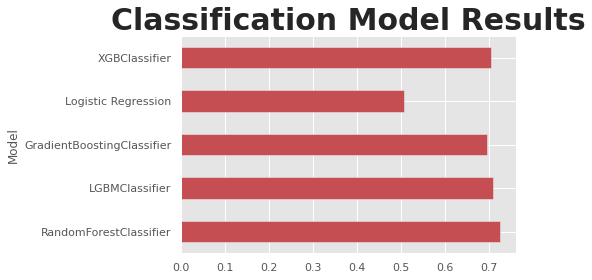

In [ ]:
F1results.F1Score.plot(kind='barh',color='r')
plt.title("Classification Model Results",fontsize=30,weight='bold')
plt.show()


*  F1 점수 **RandomForestClassifier (0.725)** > LGBMClassifier > XGBClassifier 순서대로 높음
*  RandomForestClassifier 채택하여 품질 예측





In [ ]:
test_RF = rf_best.predict(test)

In [ ]:
submission = pd.read_csv('/content/drive/MyDrive/submission(6).csv')
wine = submission.copy() 
wine['quality'] = test_RF
wine['quality']                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    
wine.to_csv('result_wine.csv',index=False) # 제출 파일 저장

0      6
1      5
2      6
3      5
4      6
      ..
995    5
996    6
997    5
998    6
999    6
Name: quality, Length: 1000, dtype: int64

# **6. 추가적인 분석**

<Figure size 936x720 with 0 Axes>

Text(0.5, 1.0, 'Quailty')

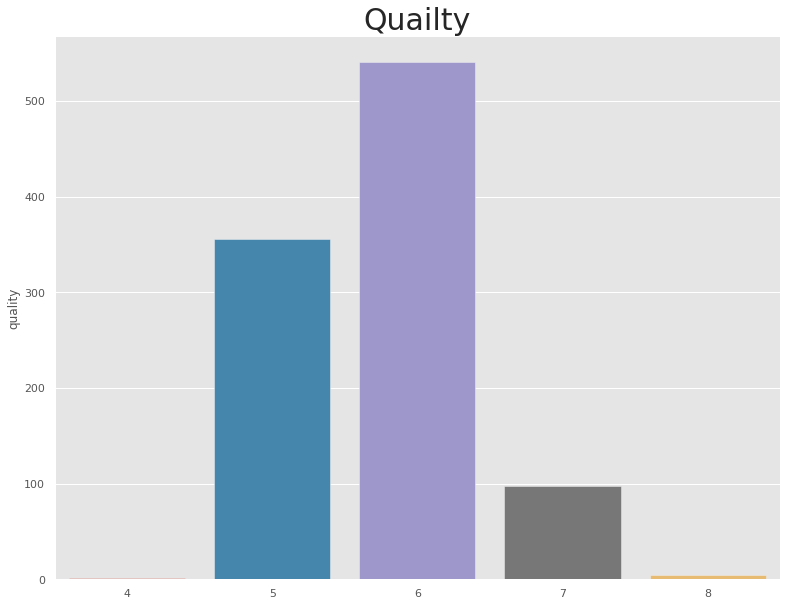

In [ ]:
# 품질 예측 결과

count = wine['quality'].value_counts()
plt.style.use('ggplot')
plt.figure(figsize=(13,10))
plt.title('Quailty',fontsize=30)
sns.barplot(x=count.index, y=count)



*  각 모델들의 예측 품질 클래스별 카운트 세어보면 여전히 3, 9에 대한 예측 수가 낮음 (3, 9의 데이터가 적어 해당 클래스에 대한 훈련이 제대로 진행되지 않았기 때문)
*   3, 9 클래스에 대한 데이터가 더 많았더라면 정확도가 더 높아졌을 것이라 생각 
*   alcohol 수치가 높고, volatile acidity (너무 높으면 불쾌한 식초 맛 유발) 수치가 낮은 와인을 사는 것이 품질 좋은 와인을 살 수 있는 방법!

